# 0 Introducción




## 0.1 Problema

En este proyecto estudiaremos un caso donde se quiere predecir el comportamiento de futuros buenos pagadores en un banco internacional.

Para lograr este objetivo generaremos distintos modelos de predicción, donde trabajaremos con la cartera de los clientes que solicitan créditos de consumo.

La descripción del problema se plantea a continuación: "Un banco internacional otorga créditos de consumo y revolving a un grupo de clientes al pasar de los meses , algunos de ellos registra morosidad, es decir no paga como se había comprometido. Ha decidido que con esta información encomendar al área de Data Science hacer un modelo para predecir el comportamiento de futuros buenos pagadores."

## 0.2 Motivación

La motivación que tenemos sobre el proyecto se debe a la relevancia que puede adquirir Machine Learning dentro de la toma de decisiones de las personas e instituciones, para tomar decisiones económicas más seguras al momento de otorgar créditos.

La implementación de Machine Learning dentro de entidades financieras permitirá disminuir el costo de tiempo para identificar a los clientes potenciales y descartar posibles deudores.

Otros puntos importantes para considerar:

* Disminución de riesgos de no pago, al efectuar un préstamo
* Segmentar el grupo de clientes para conocer el rango de crédito al que pueden acceder con menor riesgo de sobre endeudamiento
* Identificar los atributos más relevantes a la hora predecir (o determinar) el comportamiento de pago de un cliente


## 0.3 Objetivo

Predecir el comportamiento de futuros buenos pagadores, mediante la implementación de algoritmos de aprendizaje de máquina.

# 1 Preliminares

## 1.1 Definición de librerias

In [ ]:
#importamos warnings para ignorar los avisos de deprecación
import warnings
#importamos las librerias clásicas para el análisis de datos
import pandas as pd
import numpy as np
#Importamos librerias para realizar gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn

#Librerías de los modelos que utilizaremos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Con train test split haremos las matrices de entrenamiento y validación
from sklearn.model_selection import train_test_split
from sklearn import model_selection
#Para el preprocesamiento trabajaremos con StandarScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, LabelBinarizer
#Importamos librerías para el reporte de las métricas
from sklearn.metrics import classification_report, recall_score,accuracy_score,f1_score,precision_score, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from scipy.stats import ks_2samp

# Cargar de bibliotecas
from sklearn.ensemble import AdaBoostClassifier
# Import  Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

#Para realizar búsqueda de grilla con validación cruzada
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set(style="white")

# setting para visualizar todas las columnas del dataframe
pd.set_option('display.max_rows', None)

from google.colab import drive
drive.mount('/content/drive')

import os
base_path = '/content/drive/MyDrive/Portafolio/ML Clasificación - Asignación créditos/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Carga y primer procesamiento del dataset

Como primer paso importamos los archivos 'Desafio4_modelamiento.csv' y 'Desafio4_Validacion.csv' para posteriormente unirlos en un mismo dataframe para realizar el análisis exploratorio con la data completa.


Llamaremos df_inicial al dataframe generado por la concatenación de los dos datasets entregados inicialmente, reseteamos el indice y eliminamos la columna 'index'. Posteriormente, le daremos formato a las columnas eliminando espacios y dejándo todo en minúsculas. Finalmente, eliminaremos la columna SK_ID_CURR ID (Id préstamo realizado) por tratarse de un identificador único que no nos aportará ningún valor a nuestra predicción.

In [246]:
# Define las rutas de los archivos CSV
archivo_model_1 = os.path.join(base_path, 'dataset_parte1.csv')
archivo_model_2 = os.path.join(base_path, 'dataset_parte2.csv')
archivo_valid = os.path.join(base_path, 'dataset_validacion.csv')

# Carga y procesamiento de datos
df_model_1 = pd.read_csv(archivo_model_1)
df_model_2 = pd.read_csv(archivo_model_2)
df_model = pd.concat([df_model_1, df_model_2], ignore_index=True)
df_valid = pd.read_csv(archivo_valid)

df_model['dataset']='M'
df_valid['dataset']='V'

In [ ]:
def forma_dataset(df):
  print(f'El dataset presenta {df.shape[0]} registros y {df.shape[1]} variables')

In [247]:
# se identifica la forma actual del dataset de modelamiento
forma_dataset(df_model)

El dataset presenta 307511 registros y 123 variables


In [ ]:
# se identifica la forma actual del dataset de validación
forma_dataset(df_valid)

El dataset presenta 48744 registros y 122 variables


In [ ]:
# se crea la columna TARGET con valor 2 en el dataset de validación para considerar en limpieza de datos
df_valid['TARGET']=2
# se identifica la forma actual del dataset de validación
forma_dataset(df_valid)

El dataset presenta 48744 registros y 123 variables


In [ ]:
# se concatenan los dataset para limpieza general
df_inicial=pd.concat([df_model,df_valid]).reset_index().drop(columns='index')
df_inicial.drop('SK_ID_CURR',axis=1, inplace=True)
df_inicial.columns=df_inicial.columns.str.strip().str.lower()
print(f'El dataset presenta {df_inicial.shape[0]} registros y {df_inicial.shape[1]} variables')

df_inicial_copy=df_inicial.copy()

El dataset presenta 356255 registros y 122 variables


In [ ]:
def grafico_barra(df,variable,titulo):
  ax=sns.countplot(data=df, x=variable)
  for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(titulo)
  ax.get_yaxis().set_visible(False)
  plt.show()
  print('')
  return pd.DataFrame((round(df[variable].value_counts('%'),4)*100).reset_index().rename(columns={'index':'Regitros',variable:'%'})).set_index('Regitros')

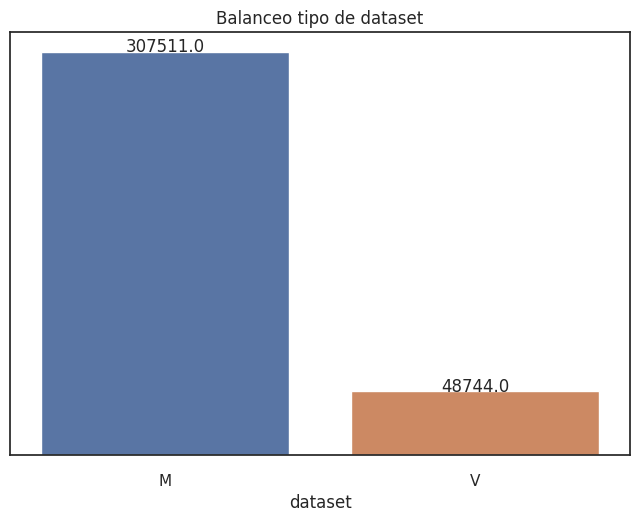

,%
Regitros,
M,86.32
V,13.68


In [ ]:
# se identifica el balanceo inicial de los dataset
grafico_barra(df_inicial,'dataset','Balanceo tipo de dataset')

In [ ]:
def tipos_dataset(df):
  return pd.DataFrame(df.dtypes.value_counts()).reset_index().rename(columns={'index':'Tipos',0:'Cantidad de Variables'})

In [ ]:
# se identifica la cantidad actual de variables por tipo
tipos_dataset(df_inicial)

,Tipos,Cantidad de Variables
0,float64,65
1,int64,40
2,object,17


In [ ]:
def cantidad_nulos(df,variable):
  print(f'''La variable {variable} tiene {df['target'].isna().sum()} valores nulos''')

In [ ]:
# se identifica la cantidad de nulos en la variable objetivo
cantidad_nulos(df_inicial,'target')

La variable target tiene 0 valores nulos


In [ ]:
forma_dataset(df_inicial)

El dataset presenta 356255 registros y 122 variables


Podemos notar que en la primera limpieza del dataframe inicial eliminamos los datos donde el vector objetivo "TARGET" era nulo, nuestro df_inicial quedó reducido en un 14% aproximadamente, pasando de 356255 filas a 307511 filas.

## 1.3 Selección de préstamos a evaluar

Para realizar la selección de cartera procedimos a visualizar gráficamente la estrutura de ambas, pudiendo notar que hay un desbalance significativo en el que la cartera cash loans cuenta con una cantidad de datos disponibles mucho mayor (un 90% aproximadamente) que la cartera de revolving loans (un 10% aproximadamente).

Lo que nos lleva a hacer una inspección del comportamiento de ambas carteras respecto del vector objetivo TARGET. Donde pudimos notar que la proporción entre buenos y malos pagadores que presentaron ambas carteras fue similar.

Dado ello, trabajaremos con la cartera "Cash Loans" dado que tiene disponible un mayor número de registros.

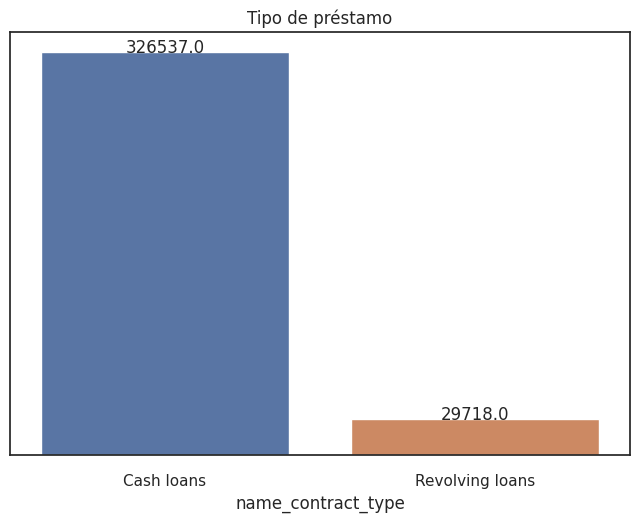

,%
Regitros,
Cash loans,91.66
Revolving loans,8.34


In [ ]:
# se observa el balance de préstamos en el dataset
grafico_barra(df_inicial,'name_contract_type','Tipo de préstamo')

In [ ]:
def grafico_barra_hue(df,variable1,variable2,titulo):
  ax=sns.countplot(x=variable1,hue=variable2,data=df)
  for rect in ax.patches:
    ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(titulo)
  ax.get_yaxis().set_visible(False)
  plt.show()
  print('')
  dinamica_temp=pd.pivot_table(df,values='flag_own_car',index=variable1,columns=variable2,aggfunc='count',fill_value=0,margins=True)
  return round(dinamica_temp.div(dinamica_temp.iloc[:,-1], axis=0),4)*100

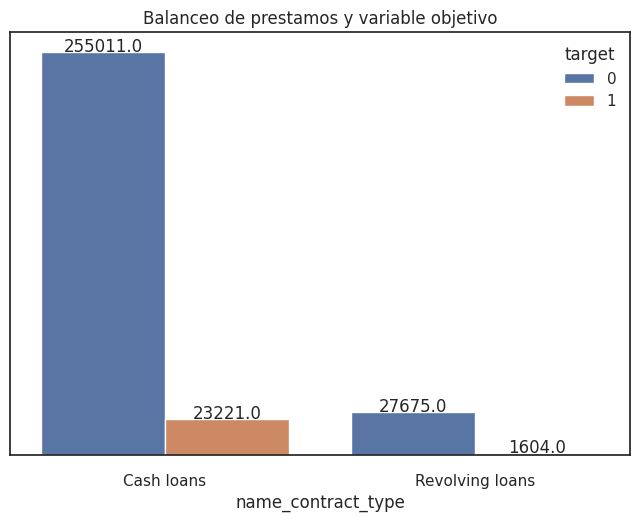

target,0,1,All
name_contract_type,,,
Cash loans,91.65,8.35,100.0
Revolving loans,94.52,5.48,100.0
All,91.93,8.07,100.0


In [ ]:
# visualizamos el balance del vector objetivo en cada cartera
grafico_barra_hue(df_inicial[df_inicial['target']!=2],'name_contract_type','target','Balanceo de prestamos y variable objetivo')

Una vez seleccionada la cartera "CASH LOANS" procederemos a filtrar los datos
que pertenecen a dicha cartera y nombraremos el dataframe: df_cash. Luego verificamos la cantidad de filas y columnas con las que finalmente trabajaremos, obteniendo un total de 278232 filas y 120 columnas. Mediante info, obtendremos la información acerca del tipo de datos que tenemos.

In [ ]:
# se crea dataset solo para Cash loans y se elimina la columna de tipo de contrato al convertirse en valor único
df_cash=df_inicial[df_inicial['name_contract_type']=='Cash loans']
df_cash=df_cash.drop(columns='name_contract_type')
df_cash_copy=df_cash.copy()

forma_dataset(df_cash)

El dataset presenta 326537 registros y 121 variables


### 1.3.1 Información general conjunto de datos

In [ ]:
def info_dataset(df):
  df.info(verbose=True, show_counts=True)

In [ ]:
info_dataset(df_cash)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326537 entries, 0 to 356254
Data columns (total 121 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    target                        326537 non-null  int64  
 1    code_gender                   326537 non-null  object 
 2    flag_own_car                  326537 non-null  object 
 3    flag_own_realty               326537 non-null  object 
 4    cnt_children                  326537 non-null  int64  
 5    amt_income_total              326537 non-null  float64
 6    amt_credit                    326537 non-null  float64
 7    amt_annuity                   326501 non-null  float64
 8    amt_goods_price               326537 non-null  float64
 9    name_type_suite               324619 non-null  object 
 10   name_income_type              326537 non-null  object 
 11   name_education_type           326537 non-null  object 
 12   name_family_status          

## 1.4 Identificación de la variable objetivo

Visualizamos nuevamente el balance de variable objetivo "Target" en la cartera seleccionada para observar con mayor detalle su distribución respecto del vector objetivo. Haciendo esto pudimos identificar que la variable objetivo "Target" presenta un desbalance significativo. En ello, un ~92% de los registros están asociados a la clase 0, es decir, clientes que son buenos pagadores. Por otro lado, un ~8% de los registros están asociados a la clase 1, es decir, clientes que son malos pagadores.

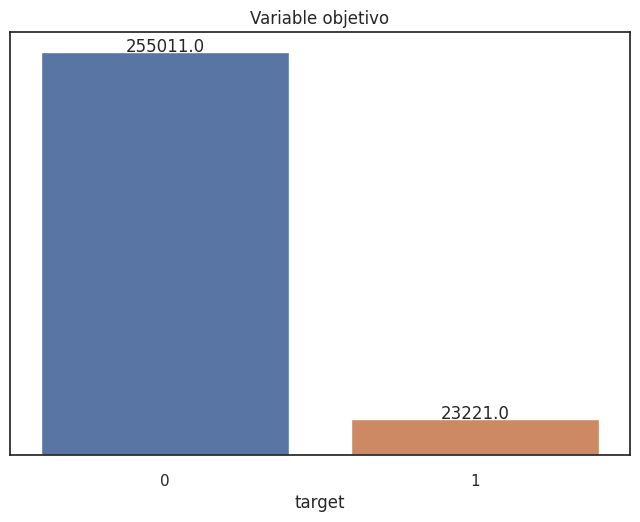

,%
Regitros,
0,91.65
1,8.35


In [ ]:
# se observa el balance de la variable objetivo
grafico_barra(df_cash[df_cash['target']!=2],'target','Variable objetivo')

## 1.5 Criterio de eliminación de variables: Variables que no presentan varianza

Existen variables que no poseen varianza, es decir, casi la totalidad de los valores que toma la variable son el mismo. Esta condición limita su capacidad de aportar en la explicación de la variable objetivo, ya que no podemos identificar y relacionar patrones a su comportamiento. Dado ello, se decide que si existe algún valor que toma una variable que constituye el 98% o más de los registros, entonces dicha variable será eliminada del conjunto de datos.

In [ ]:
def eliminar_variables_baja_varianza(df,no_considerar1,no_considerar2):
  vars_sin_varianza = []
  for col_ in df.columns[~(df.columns.isin([no_considerar1,no_considerar2]))]:
    df_temp = pd.DataFrame(df[col_].value_counts('%')).reset_index()
    df_temp.columns = ['value', 'count']
    if df_temp[df_temp['count'] > 0.98].shape[0] > 0:
      vars_sin_varianza.append(col_)
  df.drop(vars_sin_varianza, axis=1, inplace=True)

In [ ]:
# se realiza una limpieza para todas las variables que tengan una varianza superior al 98%

eliminar_variables_baja_varianza(df_cash,'target','dataset')
forma_dataset(df_cash)

El dataset presenta 326537 registros y 97 variables


In [ ]:
tipos_dataset(df_cash)

,Tipos,Cantidad de Variables
0,float64,63
1,int64,20
2,object,14


## 1.6 Criterio de eliminación de variables: Eliminación atributos con un 40% o más de valores nulos

A continuación inspeccionamos los atributos para identificar aquellos que poseen un 40% o más de valores nulos. Es decir, un 40% o más de los registros no poseen valor alguno. La intención es eliminar aquellos atributos que no indican relación en una gran parte de los registros, ya que limita su capacidad de asociación con el vector objetivo.

In [ ]:
def matriz_nulos(df):
  return msgn.matrix(df)

<Axes: >

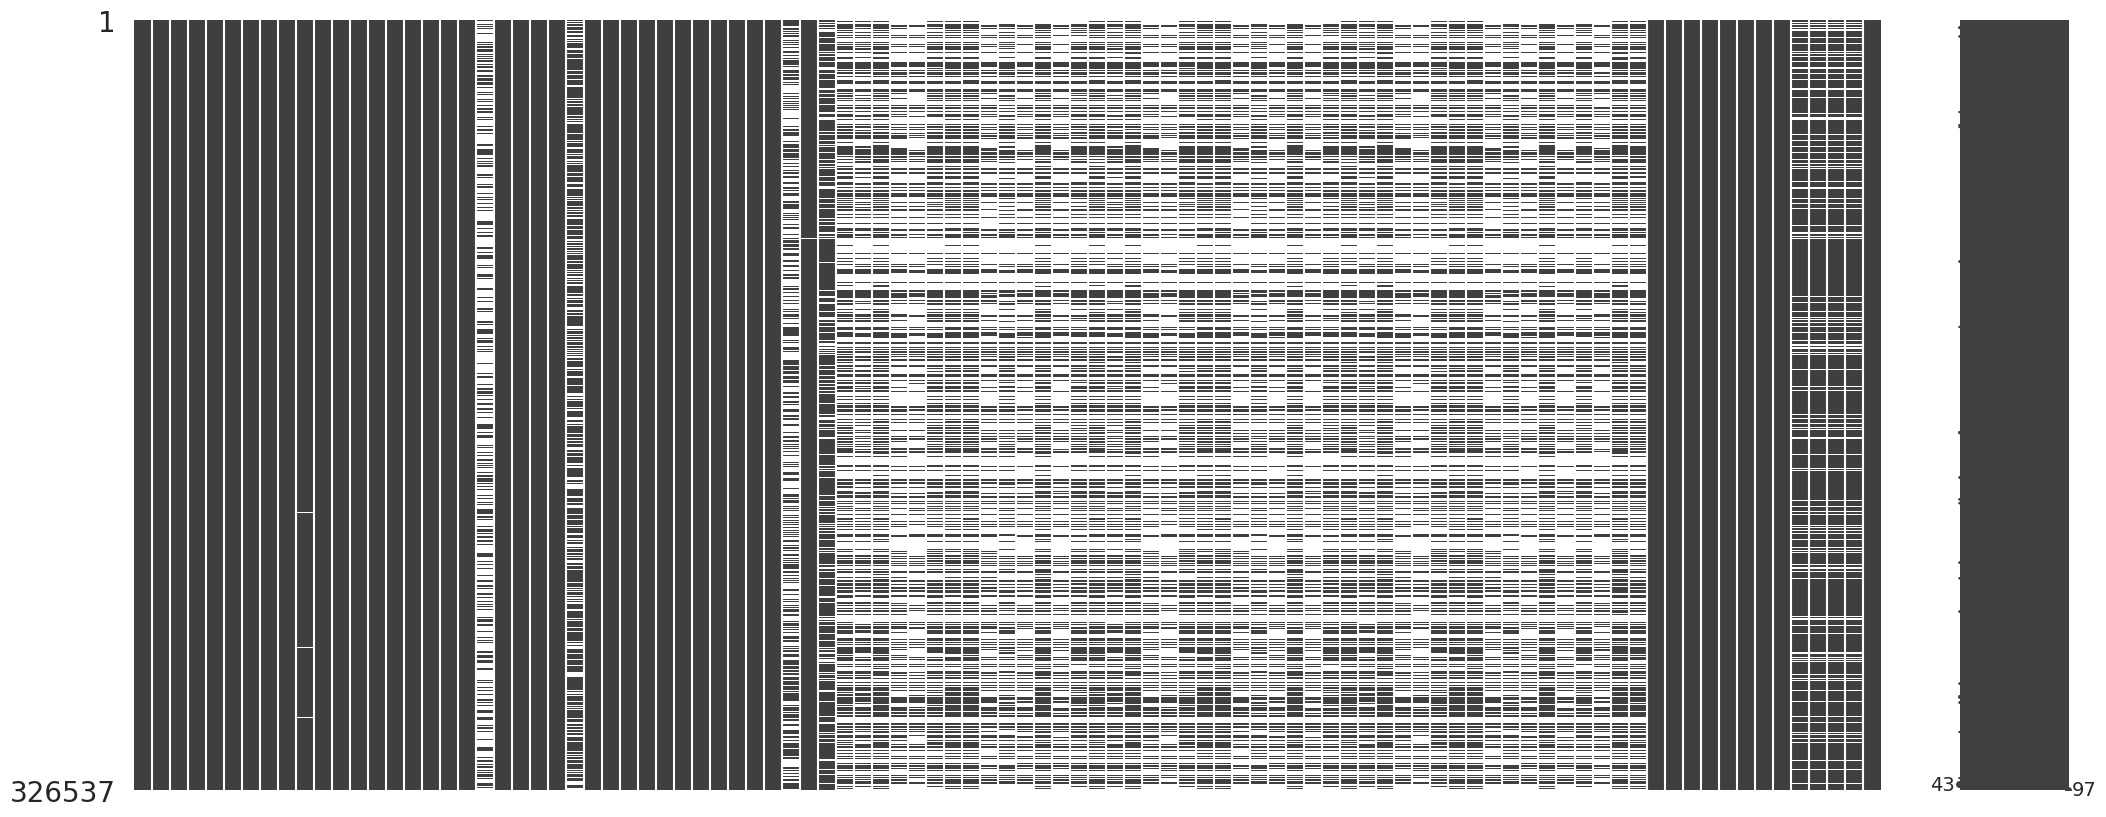

In [ ]:
# se visualiza la cantidad de nulos actuales del dataset
matriz_nulos(df_cash)

In [ ]:
# se realiza una limpieza para todas las variables que presenten más del 40% de sus valores nulos
# creamos listas con: conteo de valores nulos, porcentaje de valores nulos y nombres de las variables
# visualizamos aquellos atributos con un 40% o más de valores nulos

nulos_cash = list(df_cash.isna().sum())
porcentaje_cash = list(round(df_cash.isna().sum() / len(df_cash), 4) * 100)
columnas_cash = df_cash.columns
df_nulos = pd.DataFrame(zip(columnas_cash, nulos_cash, porcentaje_cash)).rename(columns={0: 'Variable', 1: 'Cantidad', 2: '%'})
df_nulos = df_nulos[df_nulos['Cantidad'] != 0].sort_values(by='Cantidad', ascending=False).reset_index(drop=True)
df_nulos_temp=df_nulos.set_index('Variable')
corte_nulos = df_nulos[df_nulos['%']>40].reset_index()
print(f'Hay {len(df_nulos)} variables con valores nulos sobre {40}%')
print('')
df_nulos_temp[(df_nulos_temp['%']>40)]

Hay 61 variables con valores nulos sobre 40%



,Cantidad,%
Variable,,
commonarea_medi,228444,69.96
commonarea_avg,228444,69.96
commonarea_mode,228444,69.96
nonlivingapartments_mode,227119,69.55
nonlivingapartments_avg,227119,69.55
nonlivingapartments_medi,227119,69.55
fondkapremont_mode,223724,68.51
livingapartments_avg,223565,68.47
livingapartments_mode,223565,68.47


Podemos notar que las variables que tienen un porcentaje mayor al 40% de nulos, corresponden a información normalizada sobre las características del lugar donde vive el cliente:

- Cantidad de habitaciones.
- Tamaño del inmueble.
- Áreas comunes.
- Áreas de living.
- Antigüedad en años de la construcción del edificio o vivienda.
- Cantidad de ascensores.
- Cantidad de entradas.
- Estado del edificio.
- Número del piso donde reside.

Estas son las variables en total que nos dan información habitacional del cliente, podemos observar que las variables que eliminaremos son justamente de este grupo.
- APARTMENTS_AVG.
- BASEMENTAREA_AVG.
- YEARS_BEGINEXPLUATATION_AVG.
- YEARS_BUILD_AVG.
- COMMONAREA_AVG.
- ELEVATORS_AVG.
- ENTRANCES_AVG.
- FLOORSMAX_AVG.
- FLOORSMIN_AVG.
- LANDAREA_AVG.
- LIVINGAPARTMENTS_AVG.
- LIVINGAREA_AVG.
- NONLIVINGAPARTMENTS_AVG.
- NONLIVINGAREA_AVG.
- APARTMENTS_MODE.
- BASEMENTAREA_MODE.
- YEARS_BEGINEXPLUATATION_MODE.
- YEARS_BUILD_MODE.
- ELEVATORS_MODE.
- ENTRANCES_MODE.
- FLOORSMAX_MODE.
- LANDAREA_MODE.
- LIVINGAPARTMENTS_MODE.
- LIVINGAREA_MODE.
- NONLIVINGAPARTMENTS_MODE.
- NONLIVINGAREA_MODE.
- APARTMENTS_MEDI.
- BASEMENTAREA_MEDI.
- YEARS_BEGINEXPLUATATION_MEDI.
- COMMONAREA_MEDI.
- ELEVATORS_MEDI.
- ENTRANCES_MEDI.
- FLOORSMAX_MEDI.
- FLOORSMIN_MEDI.
- LANDAREA_MEDI.
- LIVINGAPARTMENTS_MEDI.
- LIVINGAREA_MEDI.
- NONLIVINGAPARTMENTS_MEDI.
- NONLIVINGAREA_MEDI.
- FONDKAPREMONT_MODE.
- HOUSETYPE_MODE.
- TOTALAREA_MODE.
- WALLSMATERIAL_MODE.
- EMERGENCYSTATE_MODE.

In [ ]:
# se crea dataset limpio
df_clean=df_cash.drop(columns=df_nulos[df_nulos['%']>40]['Variable'])
forma_dataset(df_clean)

El dataset presenta 326537 registros y 50 variables


Habiendo eliminado las variables que presentaban una cantidad considerable de nulos, aun nos quedan variables que tienen cantidades notables de nulos. Como lo podemos observar en e gráfico anterior tenemos: ● OCCUPATION_TYPE: Cuál es la profesión del cliente, ●EXT_SOURCE_2:Puntaje normalizado de fuente externa.
- EXT_SOURCE_3: Puntaje normalizado de fuente externa. ●AMT_ANNUITY: Anualidad del préstamo.
- AMT_REQ_CREDIT_BUREAU_WEEK: Cantidad de consultas sobre el cliente al buró de crédito. Una semana antes de la postulación.
- AMT_REQ_CREDIT_BUREAU_MON: Cantidad de consultas sobre el cliente al buró de crédito. Un mes antes de la postulación.
- AMT_REQ_CREDIT_BUREAU_QRT: Cantidad de consultas sobre el cliente al buró de crédito. Tres meses antes de la postulación.
- AMT_REQ_CREDIT_BUREAU_YEAR: Cantidad de consultas sobre el cliente al buró de crédito. Un año antes de la postulación.
- NAME_TYPE_SUITE: Quien acompaña al cliente cuando fue a solicitar el préstamo.
OBS_30_CNT_SOCIAL_CIRCLE: Cuántas veces ha registrado mora más de 30 días su entorno.
- DEF_30_CNT_SOCIAL_CIRCLE: Cuántas veces ha registrado mora más de 30 días su entorno.
- OBS_60_CNT_SOCIAL_CIRCLE: Cuántas veces ha registrado mora más de 60 días su entorno.
- DEF_60_CNT_SOCIAL_CIRCLE: Cuántas veces ha registrado mora más de 60 días su entorno.
- DAYS_LAST_PHONE_CHANGE: Hace cuantos días antes de la postulación cambia número de teléfono.



A estas 14 variables les aplicaremos una recodificación en la que reemplazaremos los nulos por otros valores de la siguiente manera:
● se reemplazan los valores nulos de algunas variables categóricas por valores desconocido (unknown)
● se reemplazan los valores nulos de algunas variables continuas por su mediana
● se reemplazan los valores nulos de algunas variables continuas por 0

Posteriormente visualizaremos la matrix con los valores nulos recodificados.

<Axes: >

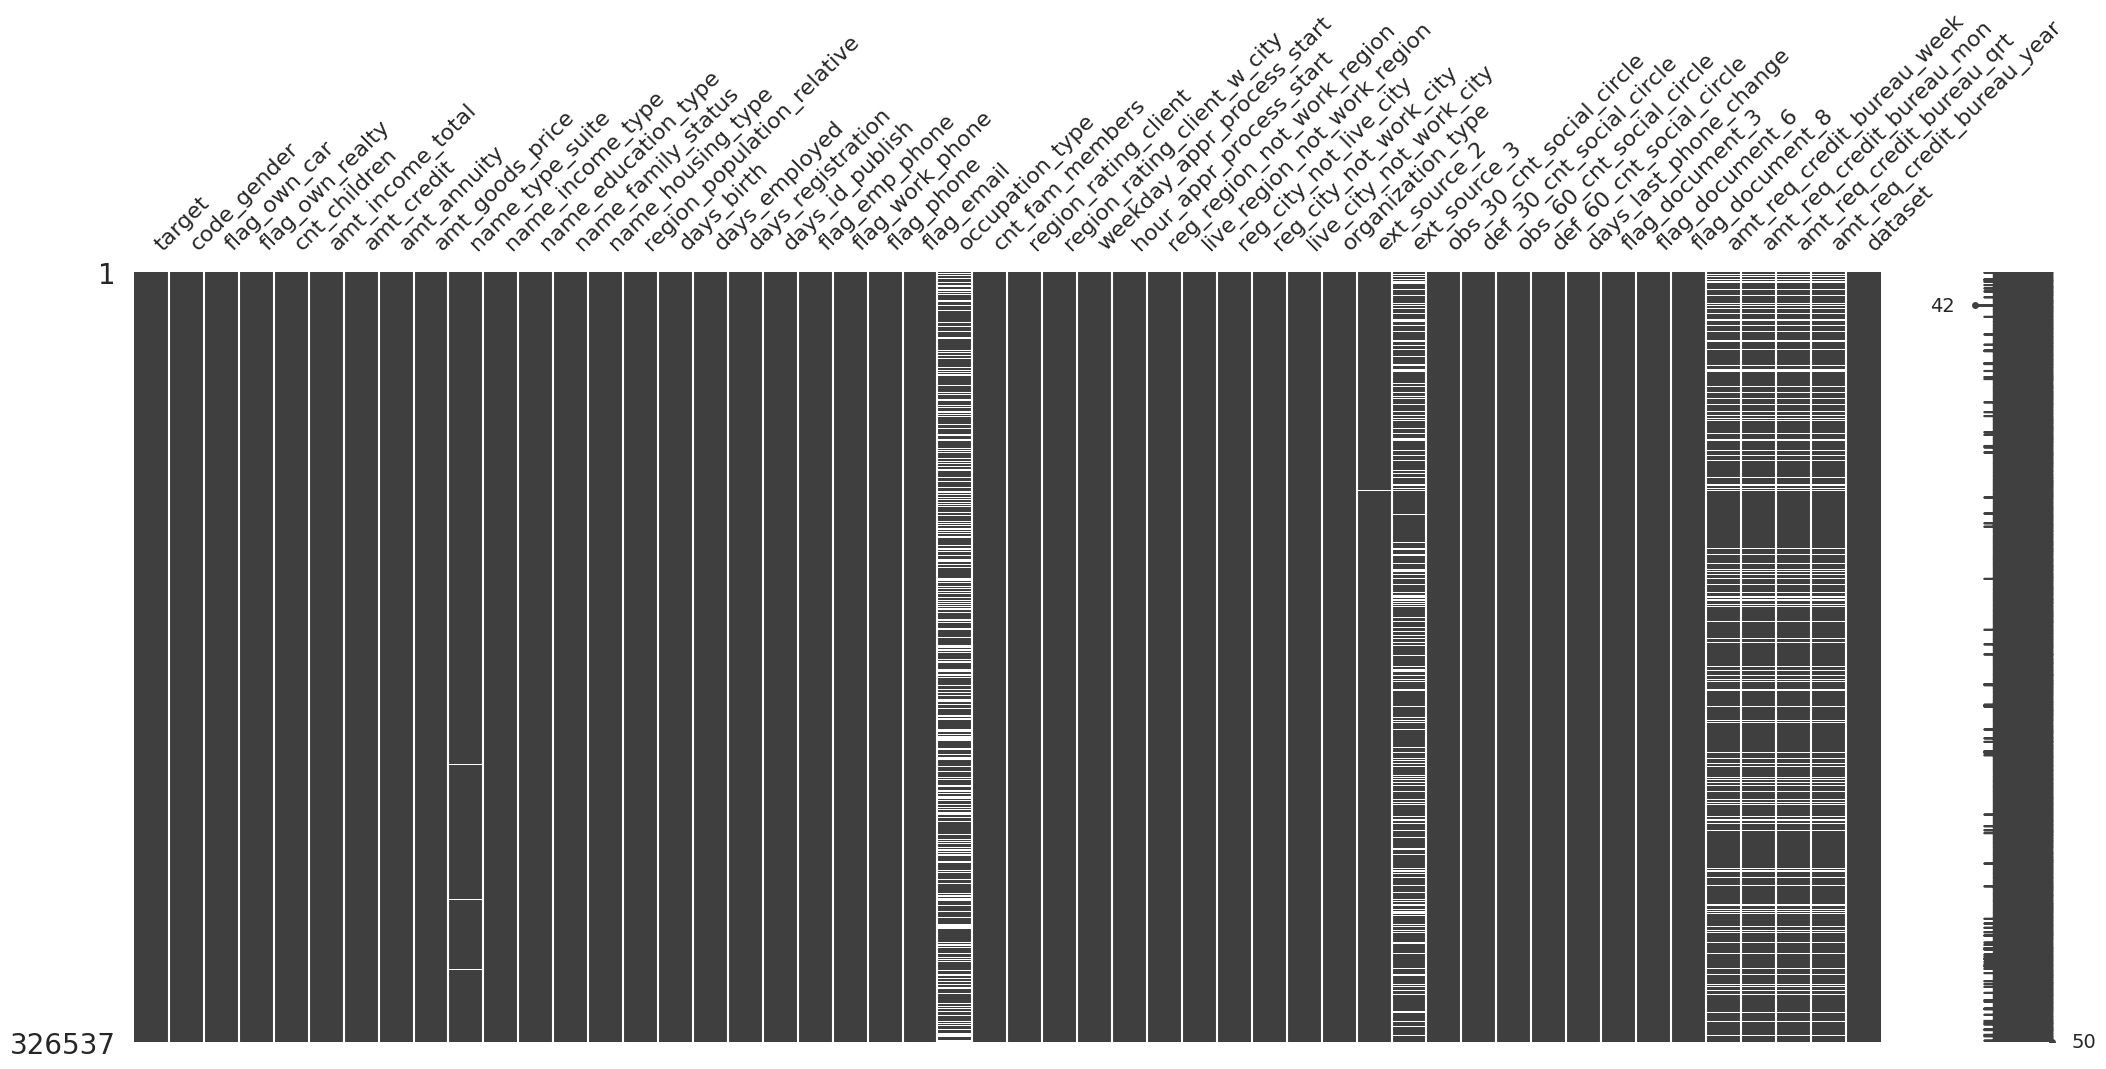

In [ ]:
# se visualiza la cantidad de nulos actuales del dataset
matriz_nulos(df_clean)

## 1.7 Criterio de recodificación: Reemplazo de nulos

In [ ]:
# se visualizan las variables restantes que presentan valores nulos
df_nulos[df_nulos['%']<=40]

,Variable,Cantidad,%
47,occupation_type,104247,31.93
48,ext_source_3,63247,19.37
49,amt_req_credit_bureau_mon,43231,13.24
50,amt_req_credit_bureau_week,43231,13.24
51,amt_req_credit_bureau_qrt,43231,13.24
52,amt_req_credit_bureau_year,43231,13.24
53,name_type_suite,1918,0.59
54,ext_source_2,606,0.19
55,amt_annuity,36,0.01
56,def_30_cnt_social_circle,2,0.00


In [ ]:
# se reemplazan los valores nulos de algunas variables categóricas por valores desconocido (unknown)
df_clean['occupation_type'] = df_clean['occupation_type'].replace(np.nan,'Unknown')
df_clean['name_type_suite'] = df_clean['name_type_suite'].replace(np.nan,'Unknown')
# se reemplazan los valores nulos de algunas variables continuas por su mediana
df_clean['ext_source_3'] = df_clean['ext_source_3'].replace(np.nan, df_clean['ext_source_3'].median())
df_clean['ext_source_2'] = df_clean['ext_source_2'].replace(np.nan, df_clean['ext_source_2'].median())
# se reemplazan los valores nulos de algunas variables continuas por 0
for i in df_clean.columns:
  df_clean[i] = df_clean[i].replace(np.nan,0)

## 1.8 Presentación de dataset libre de nulos

<Axes: >

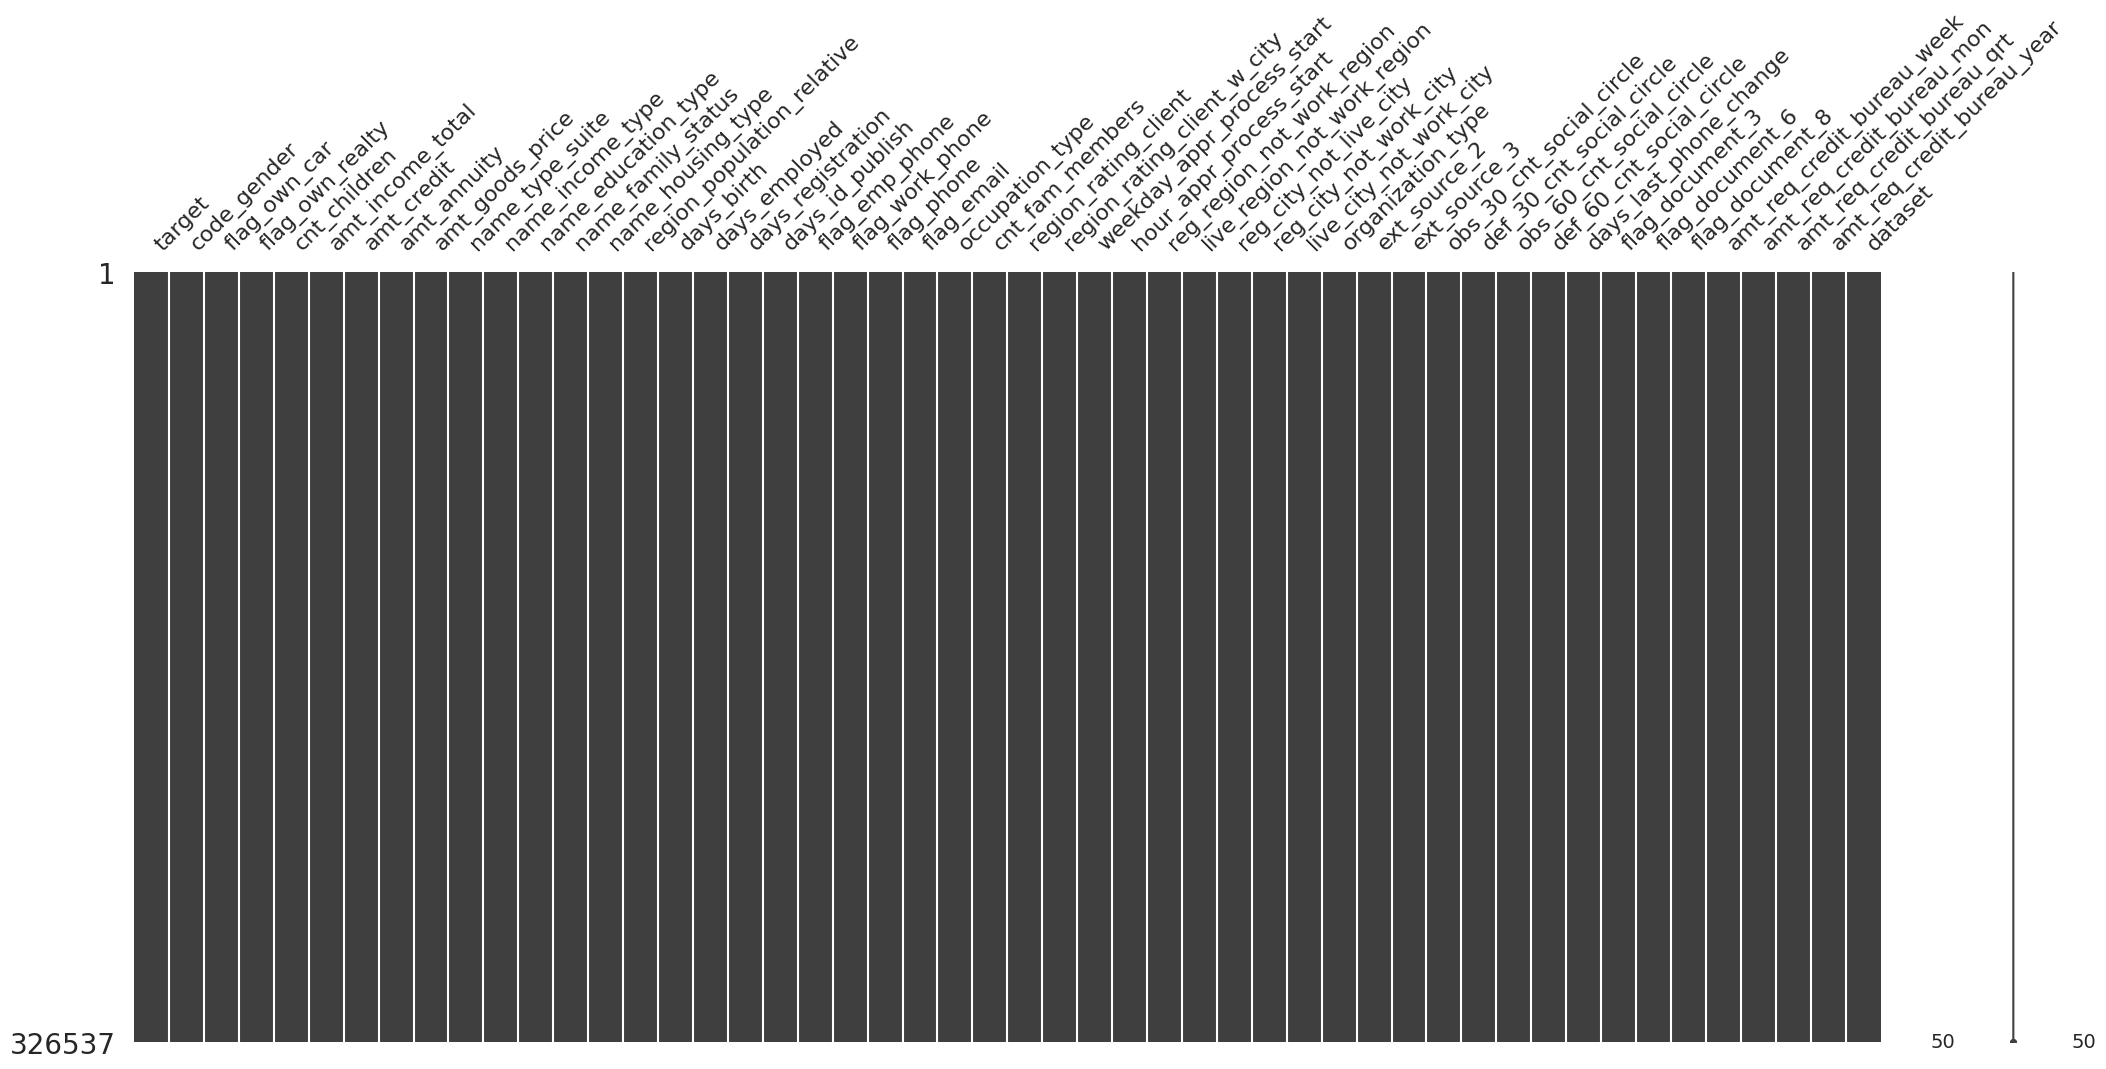

In [ ]:
# se visualiza la cantidad de nulos actuales del dataset
matriz_nulos(df_clean)

In [ ]:
# se identifica la forma actual del dataset
forma_dataset(df_clean)
df_clean_copy=df_clean.copy()

El dataset presenta 326537 registros y 50 variables


In [ ]:
# se identifica la cantidad actual de variables por tipo
tipos_dataset(df_clean)

,Tipos,Cantidad de Variables
0,int64,20
1,float64,18
2,object,12


In [ ]:
def funnel_datos(original,filtrado,limpio):
  columnas_muestra=['Index','Dataset original','Dataset filtrado','Dataset limpio']
  index=['Variables','Registros','% Datos']
  datos_originales=[len(original.columns),len(original),round(len(original)/len(original),4)*100]
  datos_filtrados=[len(filtrado.columns),len(filtrado),round(len(filtrado)/len(original),4)*100]
  datos_limpios=[len(limpio.columns),len(limpio),round(len(limpio)/len(original),4)*100]
  return pd.DataFrame(list(zip(index,datos_originales,datos_filtrados,datos_limpios)),columns=[columnas_muestra])

In [ ]:
funnel_datos(df_inicial_copy,df_cash_copy,df_clean_copy)

,Index,Dataset original,Dataset filtrado,Dataset limpio
0,Variables,122.0,121.00,50.00
1,Registros,356255.0,326537.00,326537.00
2,% Datos,100.0,91.66,91.66


## 1.9 Presentación de estadística básica por tipo de variables

Realizaremos una inspección básica de las métricas estadísticas separando por el tipo de dato: float, int y object.

In [ ]:
def estadistica_basica(df,dtype):
  return df.select_dtypes(include=[dtype]).describe().T.round(2)

In [ ]:
# se identifican las métricas básicas de estadísticas relacionadas a las variables continuas
estadistica_basica(df_clean,'float64')

,count,mean,std,min,25%,50%,75%,max
amt_income_total,326537.0,170440.65,230350.93,25650.0,112500.00,157500.00,202500.00,1.170000e+08
amt_credit,326537.0,611841.01,401641.57,45000.0,288873.00,526491.00,810000.00,4.050000e+06
amt_annuity,326537.0,28437.02,14458.74,0.0,18117.00,26100.00,35860.50,2.580255e+05
amt_goods_price,326537.0,546332.98,370034.23,40500.0,238500.00,454500.00,679500.00,4.050000e+06
region_population_relative,326537.0,0.02,0.01,0.0,0.01,0.02,0.03,7.000000e-02
days_registration,326537.0,-5004.07,3538.34,-24672.0,-7503.00,-4519.00,-2008.00,0.000000e+00
cnt_fam_members,326537.0,2.15,0.90,1.0,2.00,2.00,3.00,2.100000e+01
ext_source_2,326537.0,0.51,0.19,0.0,0.39,0.56,0.66,8.500000e-01
ext_source_3,326537.0,0.51,0.17,0.0,0.41,0.53,0.63,9.000000e-01
obs_30_cnt_social_circle,326537.0,1.44,2.57,0.0,0.00,0.00,2.00,3.540000e+02


In [ ]:
# se identifican las métricas básicas de estadísticas relacionadas a las variables continuas (enteros)
estadistica_basica(df_clean,'int')

,count,mean,std,min,25%,50%,75%,max
target,326537.0,0.37,0.73,0.0,0.0,0.0,0.0,2.0
cnt_children,326537.0,0.41,0.72,0.0,0.0,0.0,1.0,20.0
days_birth,326537.0,-16145.71,4341.42,-25201.0,-19767.0,-15860.0,-12544.0,-7338.0
days_employed,326537.0,66478.25,143490.57,-17912.0,-2798.0,-1230.0,-275.0,365243.0
days_id_publish,326537.0,-3024.70,1511.50,-7197.0,-4327.0,-3286.0,-1758.0,0.0
flag_emp_phone,326537.0,0.81,0.39,0.0,1.0,1.0,1.0,1.0
flag_work_phone,326537.0,0.20,0.40,0.0,0.0,0.0,0.0,1.0
flag_phone,326537.0,0.28,0.45,0.0,0.0,0.0,1.0,1.0
flag_email,326537.0,0.07,0.26,0.0,0.0,0.0,0.0,1.0
region_rating_client,326537.0,2.05,0.51,1.0,2.0,2.0,2.0,3.0


In [ ]:
# se identifican las métricas básicas de estadísticas relacionadas a las variables categóricas
estadistica_basica(df_clean,'object')

,count,unique,top,freq
code_gender,326537,2,F,215209
flag_own_car,326537,2,N,215808
flag_own_realty,326537,2,Y,223502
name_type_suite,326537,8,Unaccompanied,263898
name_income_type,326537,7,Working,167090
name_education_type,326537,5,Secondary / secondary special,233872
name_family_status,326537,5,Married,210713
name_housing_type,326537,6,House / apartment,290627
occupation_type,326537,19,Unknown,104247
weekday_appr_process_start,326537,7,TUESDAY,58771


# 2 Análisis univariado por variables

## 2.1 Variable objetivo

Nuestra variable objetivo es Target.

TARGET: Esta variable nos indica si el cliente tiene dificultades para pagar o no. (1 - El cliente presenta dificultades para pagar: Presenta un
pago atrasado más de X días en por lo menos en los primeros meses de pago).

En el gráfico que se muestra a continuación podemos ver que la cantidad de personas que tienen dificultades para pagar es considerablemente menor en comparación con las que no tienen dificultades de pago.


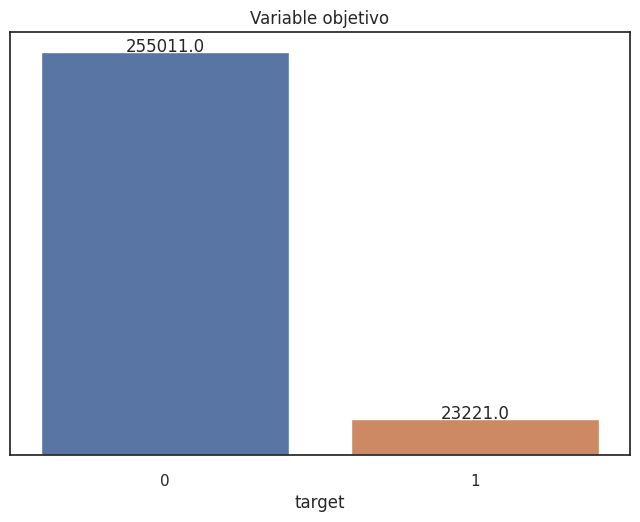

,%
Regitros,
0,91.65
1,8.35


In [ ]:
grafico_barra(df_clean[df_clean['target']!=2],'target','Variable objetivo')

## 2.2 Variable: Anualidad del préstamo (amt_annuity)

Al graficar esta variable podemos observar que presenta una gran cantidad de datos outliers, por lo que le aplicamos logaritmo para lograr una distribución más cercana a la normal, a esta nueva variable la nombramos log_amt_annuity y la graficamos para observar su distribución.

Posteriormente, se eliminará la variable original y utilizaremos la nueva variable log_amt_annuity en su lugar.

In [ ]:
info_dataset(df_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326537 entries, 0 to 356254
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   target                       326537 non-null  int64  
 1   code_gender                  326537 non-null  object 
 2   flag_own_car                 326537 non-null  object 
 3   flag_own_realty              326537 non-null  object 
 4   cnt_children                 326537 non-null  int64  
 5   amt_income_total             326537 non-null  float64
 6   amt_credit                   326537 non-null  float64
 7   amt_annuity                  326537 non-null  float64
 8   amt_goods_price              326537 non-null  float64
 9   name_type_suite              326537 non-null  object 
 10  name_income_type             326537 non-null  object 
 11  name_education_type          326537 non-null  object 
 12  name_family_status           326537 non-null  object 
 13 

In [ ]:
def grafico_log(df,variable):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  ax=sns.boxplot(data=df[variable].values)
  ax.get_xaxis().set_visible(False)
  plt.title(f'Variable {variable}')
  plt.subplot(1,2,2)
  ax=sns.kdeplot(data=np.log(df[variable]), shade=True)
  ax.get_xaxis().set_visible(False)
  plt.title(f'Variable {variable} normalizada')
  plt.show()
  print('')

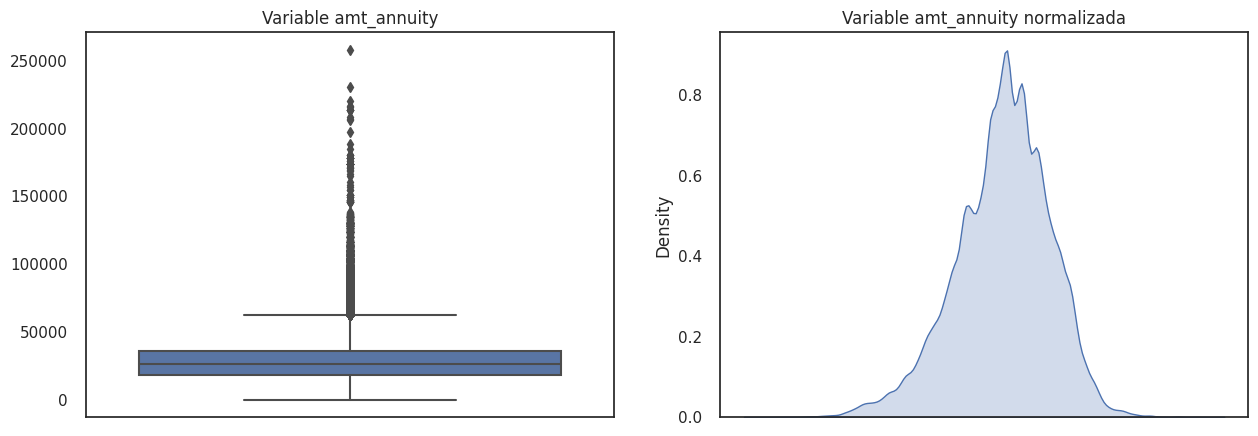

In [ ]:
grafico_log(df_clean,'amt_annuity')
df_clean['log_amt_annuity']=np.log(df_clean['amt_annuity'])
df_clean.drop('amt_annuity', axis=1, inplace=True)

## 2.3 Variable: Cantidad total del préstamo realizado (amt_credit)

Al graficar esta variable también podemos observar que presenta una gran cantidad de datos outliers, por lo que le aplicamos logaritmo para lograr una distribución más cercana a la normal, y a esta nueva variable la nombramos log_amt_credit. La graficamos para observar su distribución.

Posteriormente, se eliminará la variable original y utilizaremos la nueva variable log_amt_credit en su lugar.
Se muestra gran cantidad de datos outliers, por lo que le aplicará logaritmo a la variable para lograr una distribución más cercana a la normal.

Se eliminará la variable original.

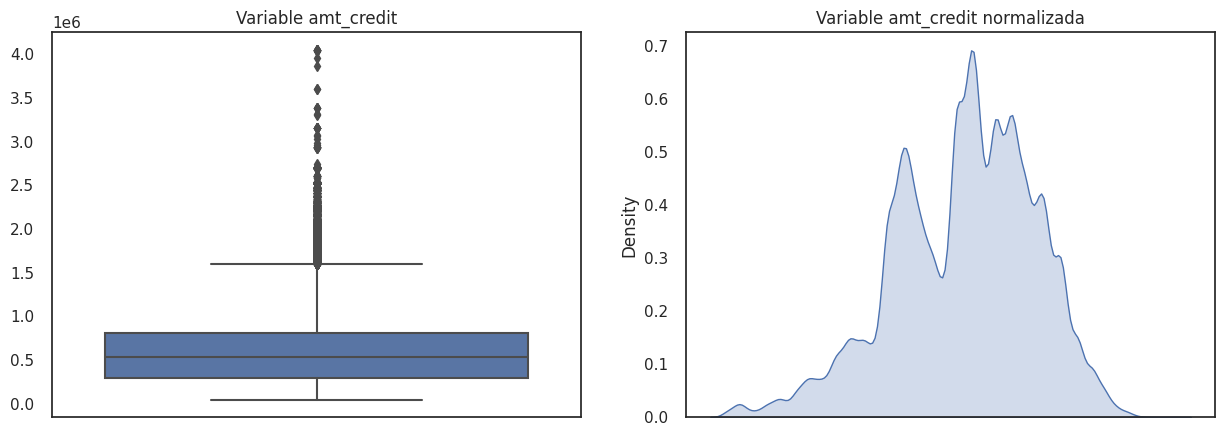

In [ ]:
grafico_log(df_clean,'amt_credit')
df_clean['log_amt_credit']=np.log(df_clean['amt_credit'])
df_clean.drop('amt_credit', axis=1, inplace=True)

## 2.4 Variable: Ingreso total del cliente (name_income_total)

La variable NAME_INCOME_TOTAL define el ingreso total del cliente, esta presenta una gran cantidad de datos outliers, por lo que le aplicará logaritmo a la variable para lograr una distribución más cercana a la normal, a esta nueva variable la nombramos como log_amt_income_total y va a reemplazar a la variable que teniamos originalmente.

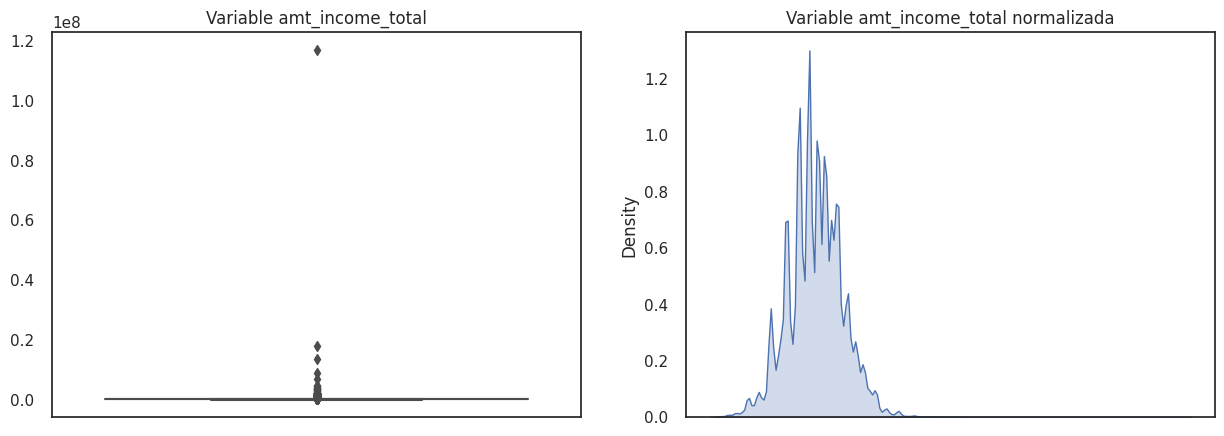

In [ ]:
grafico_log(df_clean,'amt_income_total')
df_clean['log_amt_income_total']=np.log(df_clean['amt_income_total'])
df_clean.drop('amt_income_total', axis=1, inplace=True)

## 2.5 Variable: Precio de los bienes que se comprara con el préstamo (amt_goods_price)

AMT_GOODS_PRICE: Para préstamos de consumo representa el precio de los bienes
que se comprara con el préstamo.


Se muestra gran cantidad de datos outliers, por lo que le aplicará logaritmo a la variable para lograr una distribución más cercana a la normal.

Se eliminará la variable original.


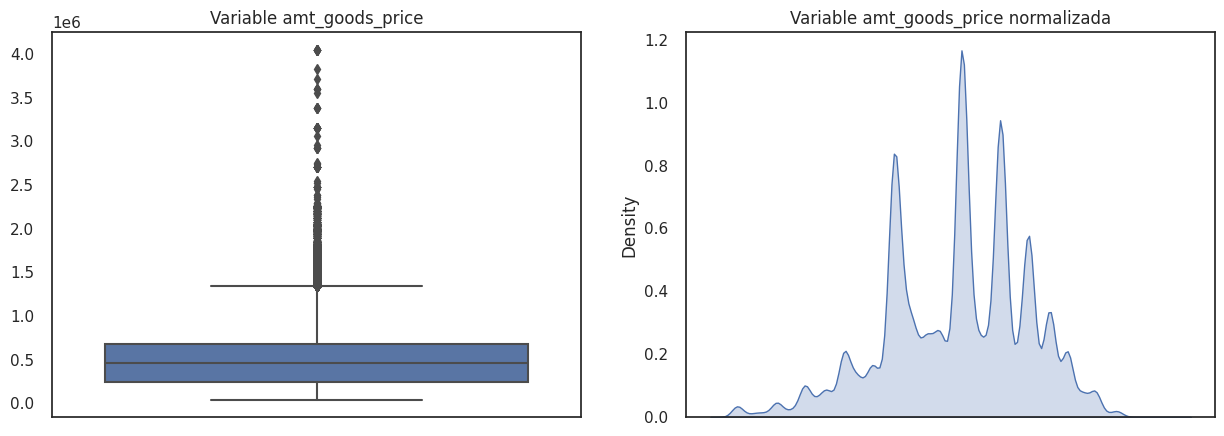

In [ ]:
grafico_log(df_clean,'amt_goods_price')
df_clean['log_amt_goods_price']=np.log(df_clean['amt_goods_price'])
df_clean.drop('amt_goods_price', axis=1, inplace=True)

## 2.6 Variable: Edad del cliente cuando solicitó el préstamo (days_birth)

La variable DAYS_BIRTH muestra la Edad del cliente cuando solicitó el préstamo, pero viene expresada en días y con valores negativos (cuenta los días desde el momento en que se registra la observación hasta el día de su nacimiento), por lo cual haremos una transformación convirtiendo los datos en años y valores positivos (trabajaremos con años de edad del cliente).
Esto nos facilita la lectura e interpretación de la información respecto de esta variable.

Posteriormente se eliminará la variable original, y trabajaremos con la nueva variable que nombramos 'age'.

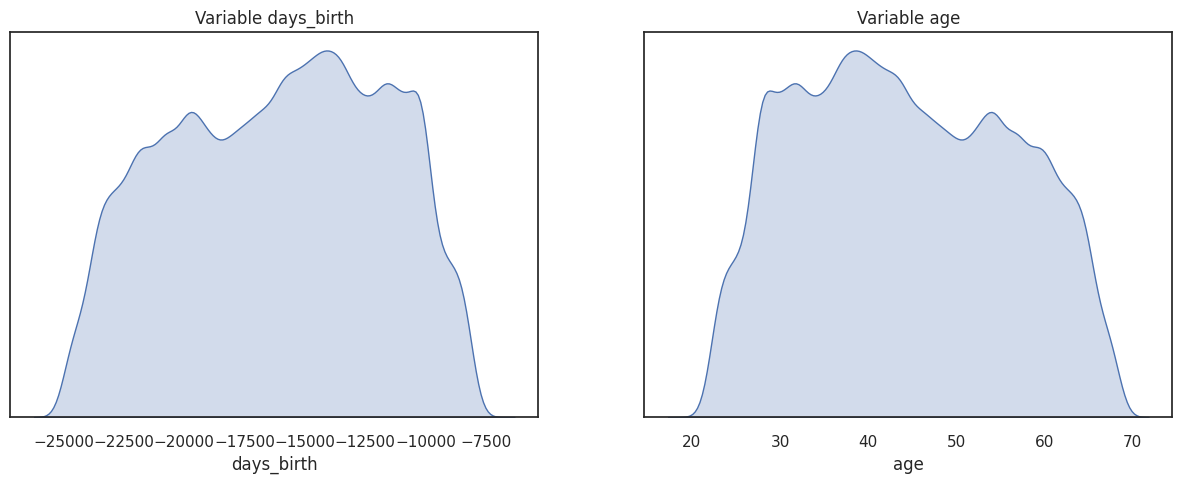

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax=sns.kdeplot(data=df_clean['days_birth'],shade=True)
ax.get_yaxis().set_visible(False)
plt.title(f'Variable days_birth')
plt.subplot(1,2,2)
df_clean['age']=(df_clean['days_birth']*-1)/365
ax=sns.kdeplot(data=df_clean['age'],shade=True)
ax.get_yaxis().set_visible(False)
plt.title(f'Variable age')

df_clean.drop('days_birth', axis=1, inplace=True)

## 2.7 Variable: Población donde vive el cliente (region_population_relative)

La variable está normalizada, donde valores más altos significan que el cliente vive en una región más poblada.

In [ ]:
def grafico_kdeplot(df,variable):
  ax=sns.kdeplot(data=df[variable],shade=True)
  plt.title(f'Variable {variable}')
  ax.get_yaxis().set_visible(False)
  plt.show()

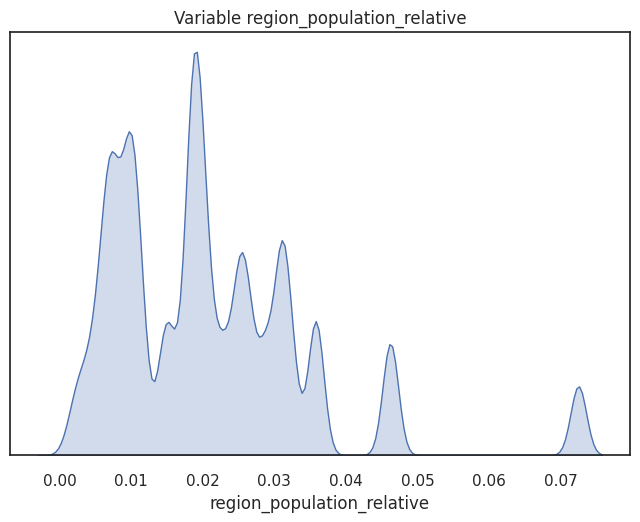

In [ ]:
grafico_kdeplot(df_clean,'region_population_relative')

## 2.8 Variable: Cantidad de días trabajados previos a la postulación (days_employed)

La variable DAYS_EMPLOYED representa la cantidad de días trabajados previos a la postulación al crédito, ésta presenta una gran concentración de datos,  por lo que la convertiremos en variable categórica que indique si el cliente posee o no días trabajados previos a la postulación.
Le llamaremos 'with_days_worked' a la nueva variable categórica.

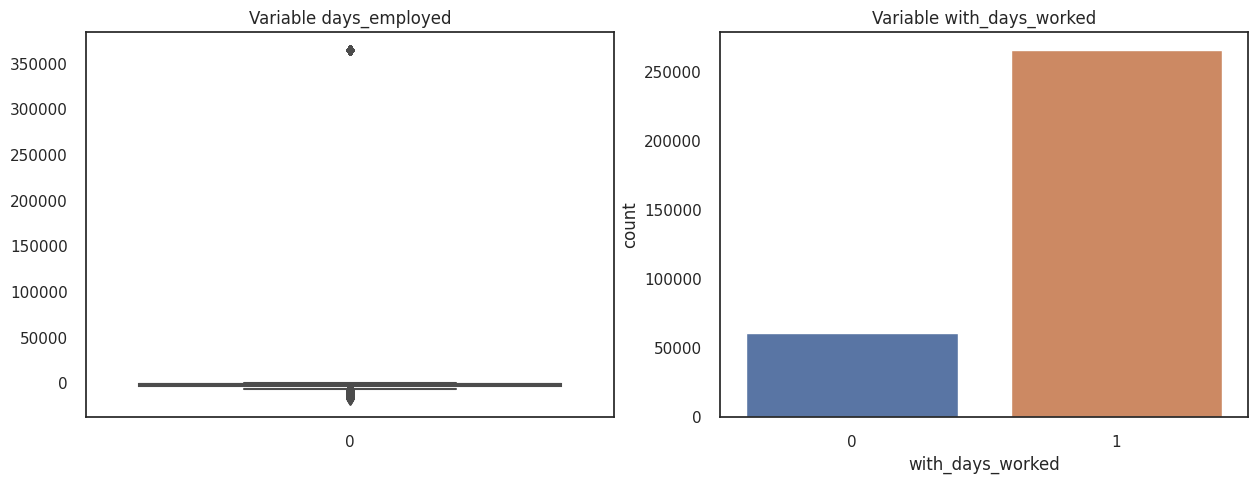

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(data=df_clean['days_employed'].values)
plt.title(f'Variable days_employed')
plt.subplot(1,2,2)
df_clean['with_days_worked'] = np.where(df_clean['days_employed']<0,1,0)
df_clean['with_days_worked'] = df_clean['with_days_worked'].astype('int')
sns.countplot(data=df_clean,x='with_days_worked')
plt.title(f'Variable with_days_worked')

df_clean.drop('days_employed', axis=1, inplace=True)

## 2.9 Variable: Cantidad de días previos a modificación de ID de postulación (days_id_publish)

DAYS_ID_PUBLISH: Cantidad de días previos a la modificación de su documento de
identificación con el cual postula al préstamo.

Se muestra gran cantidad de datos outliers, por lo que le aplicará logaritmo a la variable para lograr una distribución más cercana a la normal.

Se eliminará la variable original.

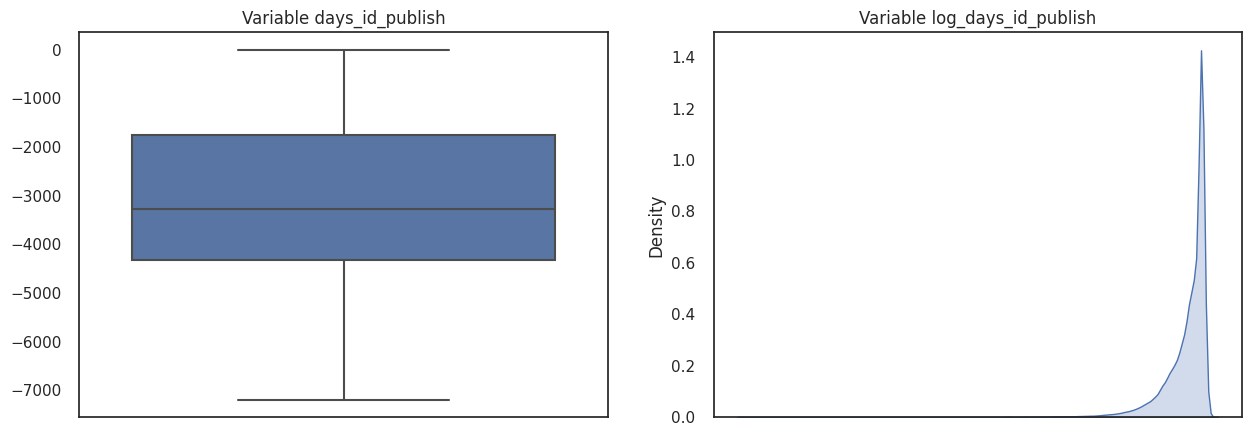

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax=sns.boxplot(data=df_clean['days_id_publish'].values)
ax.get_xaxis().set_visible(False)
plt.title(f'Variable days_id_publish')
plt.subplot(1,2,2)
df_clean['log_days_id_publish']=np.log(df_clean['days_id_publish']*-1 + 0.00001)
ax=sns.kdeplot(data=df_clean['log_days_id_publish'],shade=True)
ax.get_xaxis().set_visible(False)
plt.title(f'Variable log_days_id_publish')

df_clean.drop('days_id_publish', axis=1, inplace=True)

## 2.10 Variable: Cantidad de días previos a modificación de registros de postulación (days_registration)

DAYS_REGISTRATION: Cantidad de días previos a la última modificación de los
registros del cliente previos a la postulación.

Se muestra gran cantidad de datos outliers, por lo que le aplicará logaritmo a la variable para lograr una distribución más cercana a la normal.

Se eliminará la variable original.

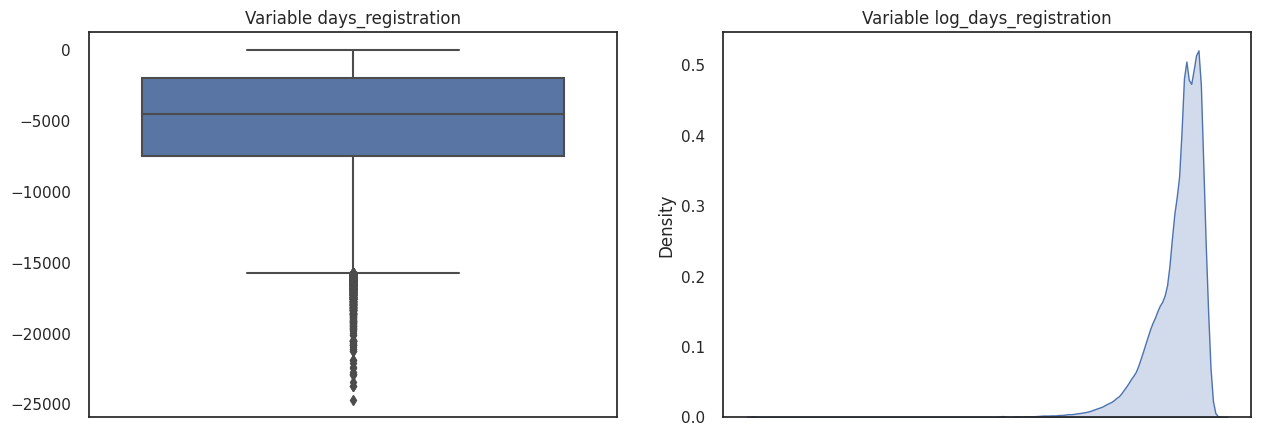

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax=sns.boxplot(data=df_clean['days_registration'].values)
ax.get_xaxis().set_visible(False)
plt.title(f'Variable days_registration')
plt.subplot(1,2,2)
df_clean['log_days_registration']=np.log(df_clean['days_registration']*-1 + 0.00001)
ax=sns.kdeplot(data=df_clean['log_days_registration'],shade=True)
ax.get_xaxis().set_visible(False)
plt.title(f'Variable log_days_registration')

df_clean.drop('days_registration', axis=1, inplace=True)

## 2.11 Variables: Puntajes normalizados de fuente externa.

Se consideran la fuente externa "ext_source_2" y "ext_source_3"

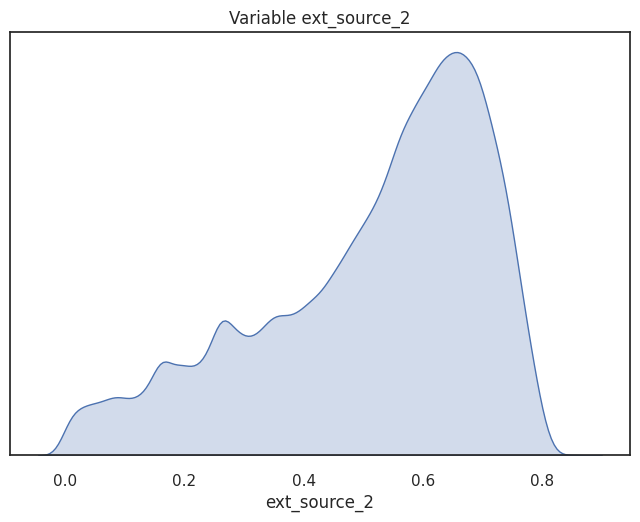

In [ ]:
grafico_kdeplot(df_clean,'ext_source_2')

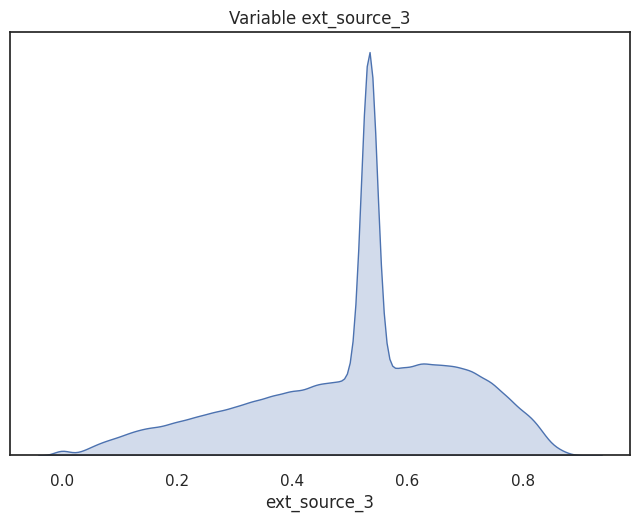

In [ ]:
grafico_kdeplot(df_clean,'ext_source_3')

## 2.12 Variable: Días previos  de la postulación cambia número de teléfono.

La variable presenta una gran concentración de datos, se convertirá en variable categórica que indique si posee o no cambio de teléfono previo a la postulación.

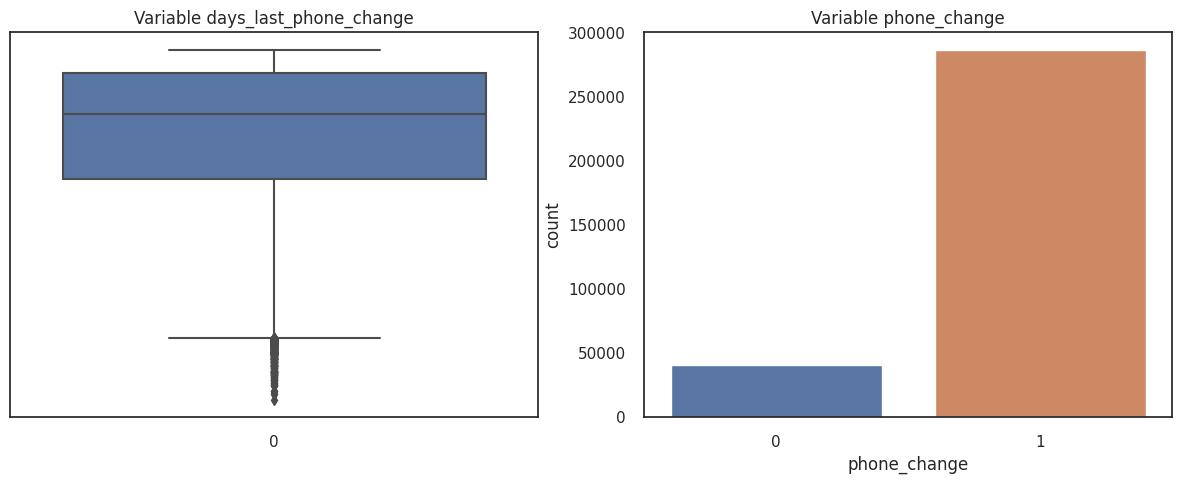

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax=sns.boxplot(data=df_clean['days_last_phone_change'].values)
ax.get_yaxis().set_visible(False)
plt.title(f'Variable days_last_phone_change')
plt.subplot(1,2,2)
df_clean['phone_change']=np.where(df_clean['days_last_phone_change']<0,1,0)
df_clean['phone_change']=df_clean['phone_change'].astype('int')
ax=sns.countplot(data=df_clean,x='phone_change')
plt.title(f'Variable phone_change')

df_clean.drop('days_last_phone_change', axis=1, inplace=True)

## 2.13 Variables: Teléfonos de contacto.

Se muestran 3 variables binarias:
1. Da un teléfono de trabajo de contacto
2. Da un teléfono contacto el cliente
3. Da un teléfono de hogar de contacto:

In [ ]:
def grafico_barra_triple(df,var1,var2,var3):
  plt.figure(figsize=(25,5))
  plt.subplot(1,3,1)
  ax=sns.countplot(data=df,x=var1)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var1}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,3,2)
  ax=sns.countplot(data=df,x=var2)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var2}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,3,3)
  ax=sns.countplot(data=df,x=var3)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var3}')
  ax.get_yaxis().set_visible(False)

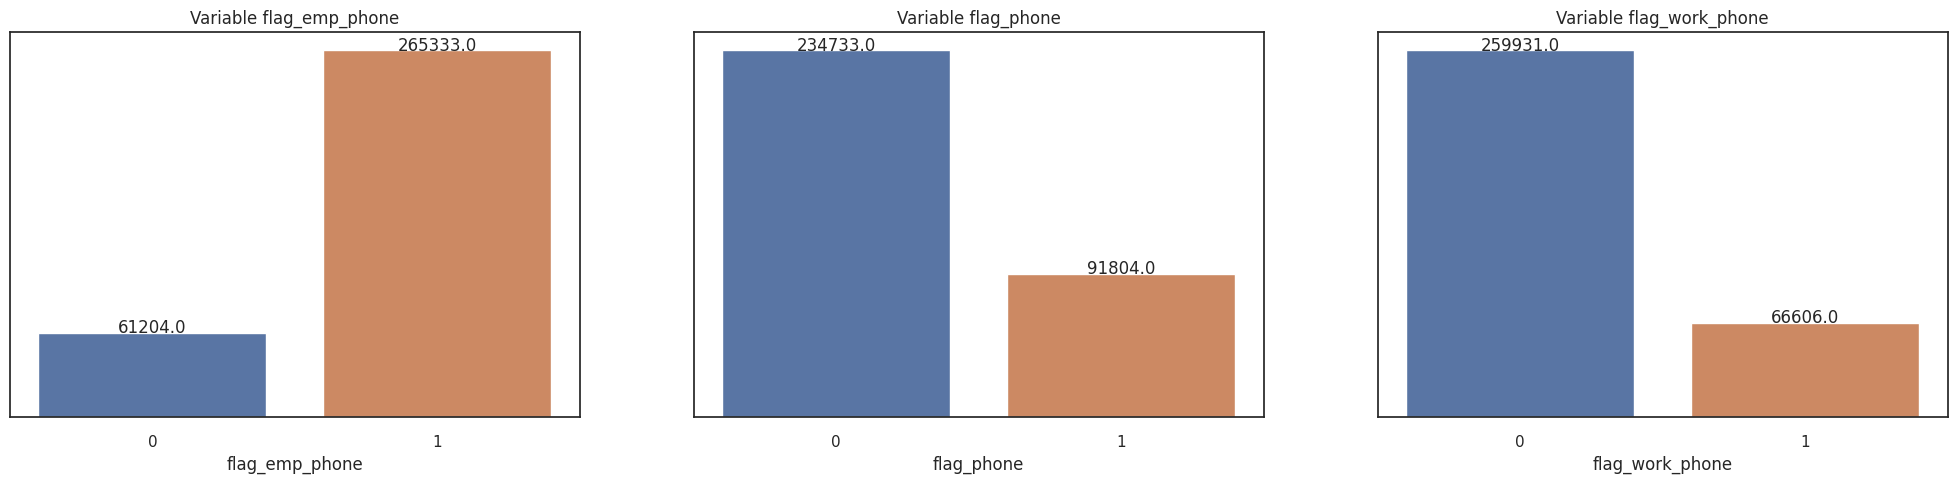

In [ ]:
grafico_barra_triple(df_clean,'flag_emp_phone','flag_phone','flag_work_phone')

## 2.14 Variables: Ciudades

Se muestran 3 variables binarias y 1 categórica:

1. Dirección de contacto del cliente no concuerda con la dirección del trabajo
2. Dirección permanente no concuerda con la dirección de contacto
3. Dirección permanente no concuerda con la dirección del trabajo
4. Evaluación interna sobre la región donde vive el cliente

In [ ]:
def grafico_barra_cuadruple(df,var1,var2,var3,var4):
  plt.figure(figsize=(25,5))
  plt.subplot(1,4,1)
  ax=sns.countplot(data=df,x=var1)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var1}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,4,2)
  ax=sns.countplot(data=df,x=var2)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var2}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,4,3)
  ax=sns.countplot(data=df,x=var3)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var3}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,4,4)
  ax=sns.countplot(data=df,x=var4)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var4}')
  ax.get_yaxis().set_visible(False)

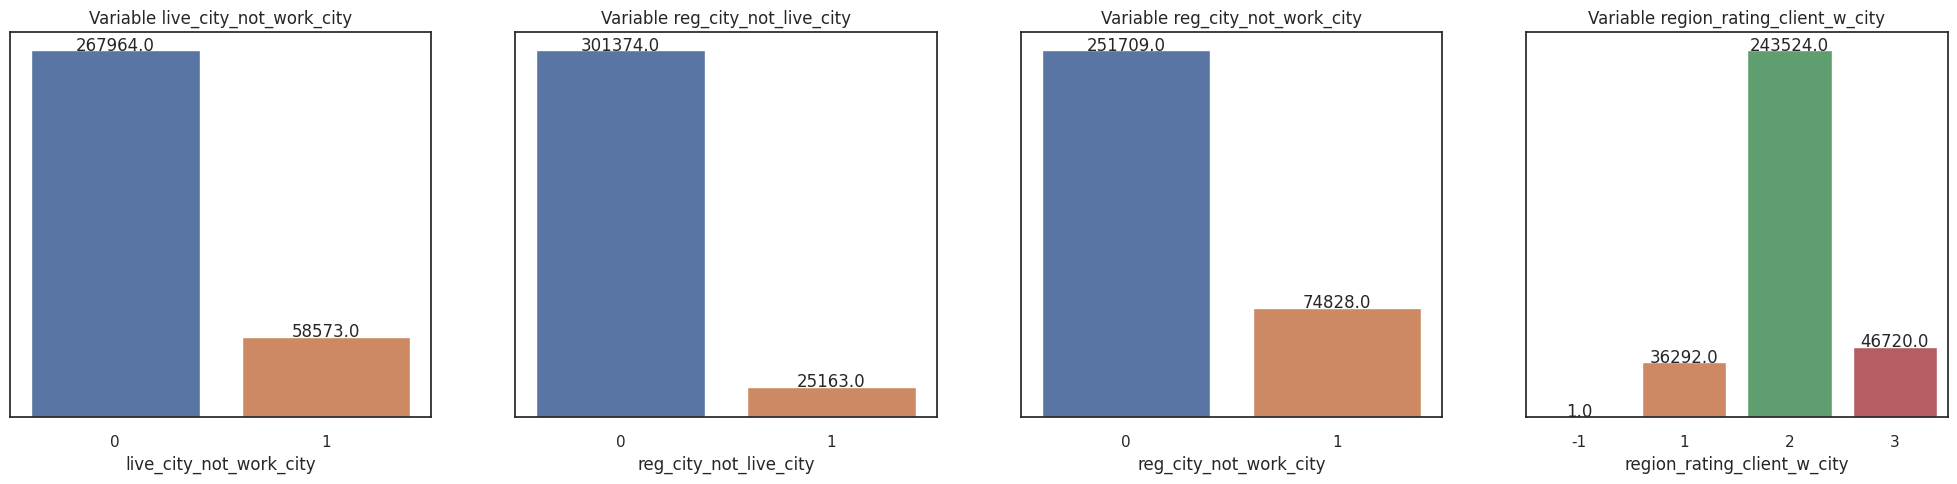

In [ ]:
grafico_barra_cuadruple(df_clean,'live_city_not_work_city','reg_city_not_live_city','reg_city_not_work_city','region_rating_client_w_city')

## 2.15 Variables: Regiones

Se muestran 2 variables binarias y 1 categórica:

1. Dirección de contacto del cliente no concuerda con la dirección del trabajo.
2. Dirección permanente del cliente no concuerda con la dirección de trabajo:
3. Evaluación interna sobre la región donde vive el cliente.

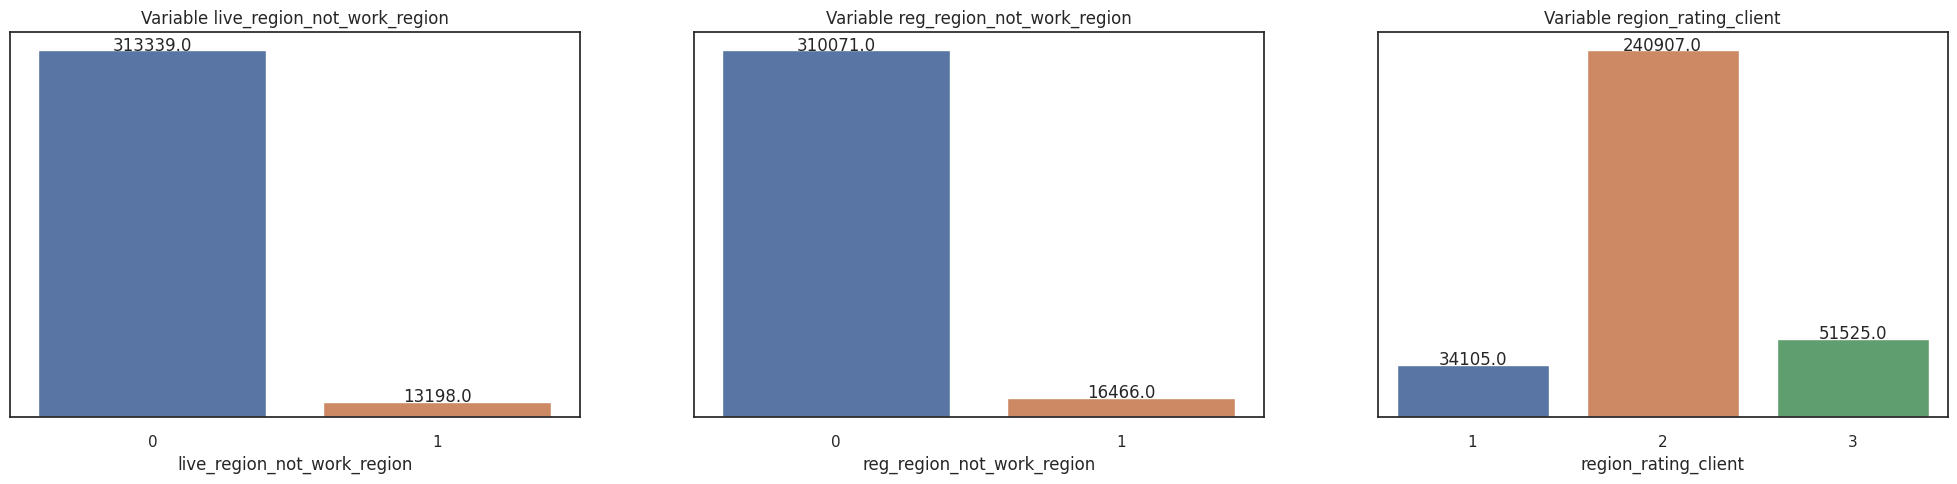

In [ ]:
grafico_barra_triple(df_clean,'live_region_not_work_region','reg_region_not_work_region','region_rating_client')

In [ ]:
df_clean.drop('live_region_not_work_region', axis=1, inplace=True)
df_clean.drop('reg_region_not_work_region', axis=1, inplace=True)

## 2.16 Variables: Morosidad

Se muestran 4 variables categóricas:
1. Cuántas veces ha registrado mora más de 30 días su entorno.
2. Cuántas veces ha registrado mora más de 60 días su entorno.
3. Cuántas veces ha registrado mora más de 30 días su entorno.
4. Cuántas veces ha registrado mora más de 60 días su entorno.

Se eliminarán 2 variables ya que se consideran los mismos registros.

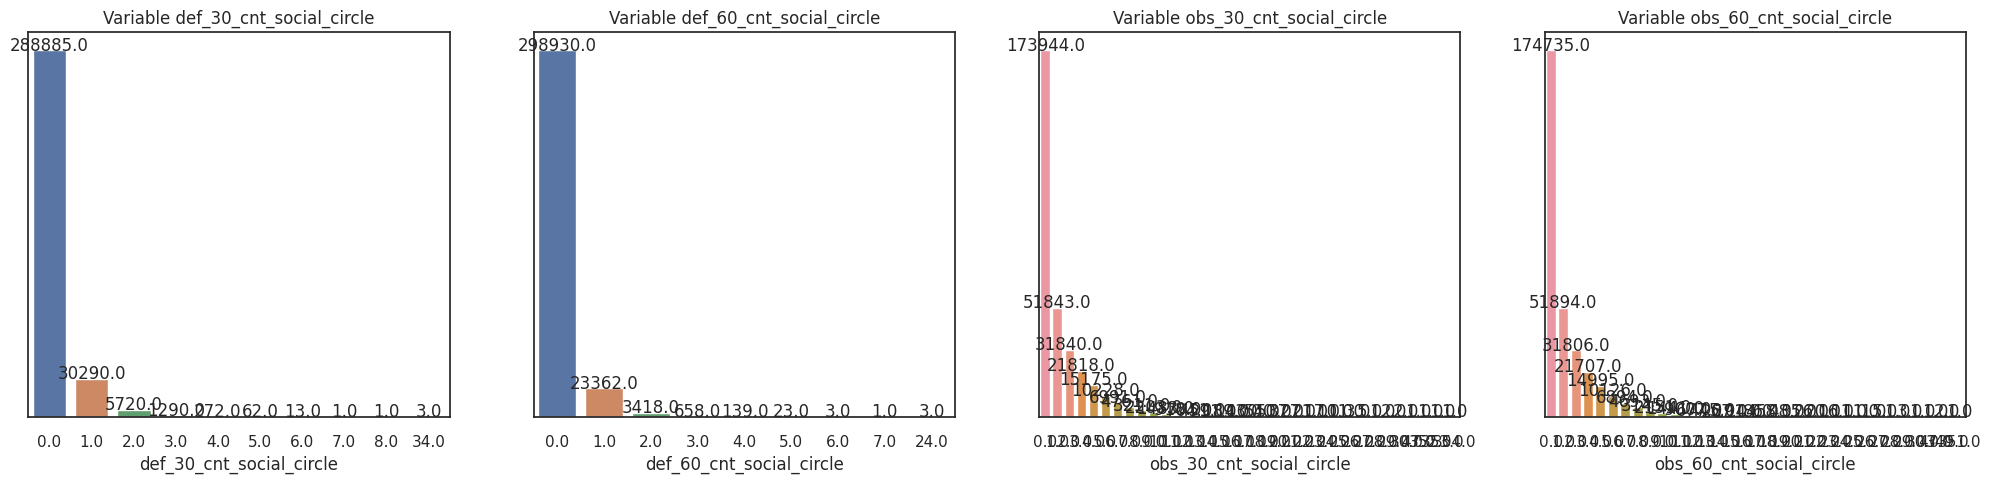

In [ ]:
grafico_barra_cuadruple(df_clean,'def_30_cnt_social_circle','def_60_cnt_social_circle','obs_30_cnt_social_circle','obs_60_cnt_social_circle')

In [ ]:
df_clean.drop('obs_30_cnt_social_circle', axis=1, inplace=True)
df_clean.drop('obs_60_cnt_social_circle', axis=1, inplace=True)

## 2.17 Variables: Consultas de crédito (amt_req_credit_bureau)

Se muestran 4 variables con las cantidades de consultas sobre el cliente al buró de crédito.
1. Un mes antes de la postulación (amt_req_credit_bureau_mon).
2. Tres meses antes de la postulación (amt_req_credit_bureau_qrt).
3. Una semana antes de la postulación (amt_req_credit_bureau_week).
4. Un año antes de la postulación (amt_req_credit_bureau_year).

Se eliminan 2 variables ('amt_req_credit_bureau_qrt' y amt_req_credit_bureau_week')  al presentar data agrupada de las variables 'amt_req_credit_bureau_year' y 'amt_req_credit_bureau_mon'.

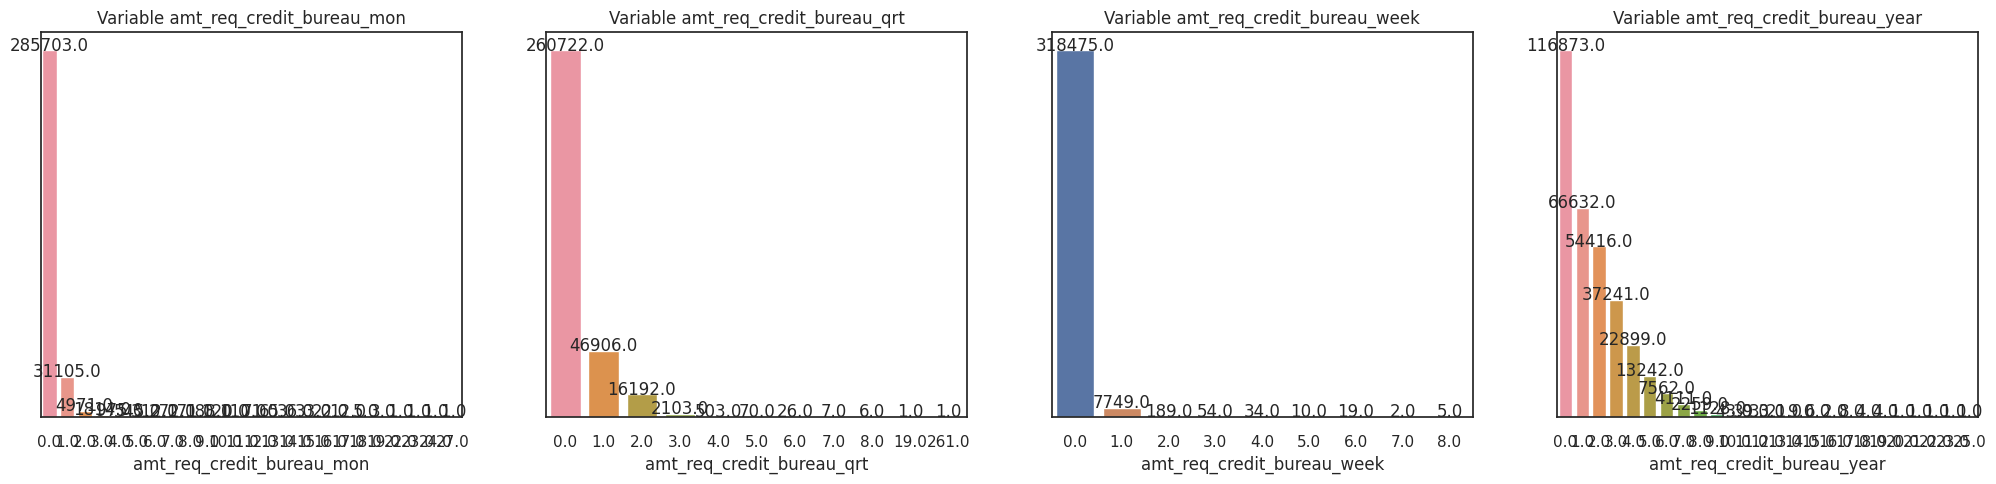

In [ ]:
grafico_barra_cuadruple(df_clean,'amt_req_credit_bureau_mon','amt_req_credit_bureau_qrt','amt_req_credit_bureau_week','amt_req_credit_bureau_year')

df_clean.drop('amt_req_credit_bureau_qrt', axis=1, inplace=True)
df_clean.drop('amt_req_credit_bureau_week', axis=1, inplace=True)

## 2.18 Variables: Familiares

Se muestran 2 variables categóricas ('cnt_children' y 'cnt_fam_members'):

1. Cantidad de hijos por parte del cliente.
2. Cuántos miembros familiares tiene el cliente.

En los gráficos podemos notar que la mayoría de los clientes que solicitan el crédito son parejas o personas solteras sin hijos.

In [ ]:
def grafico_barra_doble(df,var1,var2):
  plt.figure(figsize=(25,5))
  plt.subplot(1,2,1)
  ax=sns.countplot(data=df,x=var1)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var1}')
  ax.get_yaxis().set_visible(False)
  plt.subplot(1,2,2)
  ax=sns.countplot(data=df,x=var2)
  for rect in ax.patches:
      ax.text (rect.get_x()+rect.get_width()/2,rect.get_height()+0.75,rect.get_height(),horizontalalignment='center')
  plt.title(f'Variable {var2}')
  ax.get_yaxis().set_visible(False)

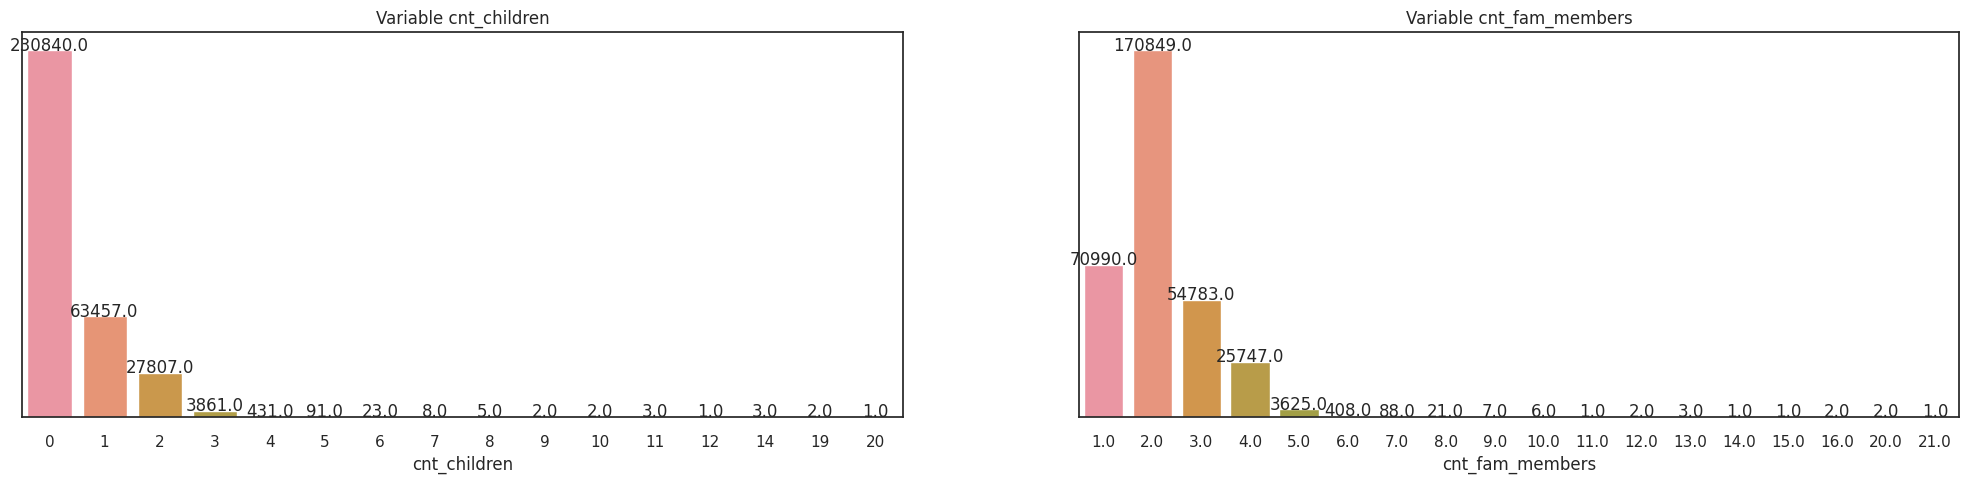

In [ ]:
grafico_barra_doble(df_clean,'cnt_children','cnt_fam_members')

## 2.19 Variables: Varias

Se presentan 4 variables binarias:
1. Sexo del cliente (code_gender).
2. Da un email de contacto el cliente (flag_email) 1: yes, 0: no.
3. Tenencia de automóvil por parte del cliente (flag_own_car).
4. Propiedad de una casa o departamento por parte del cliente (flag_own_realty).

De estos gráficos podemos observar que la cantidad de mujeres que piden el crédito es casi el doble de la cantidad de clientes hombres. Además hay una diferencia significativa entre los solicitantes que poseen auto propio y los que no, y entre los que poseen departamento propio y los que no.

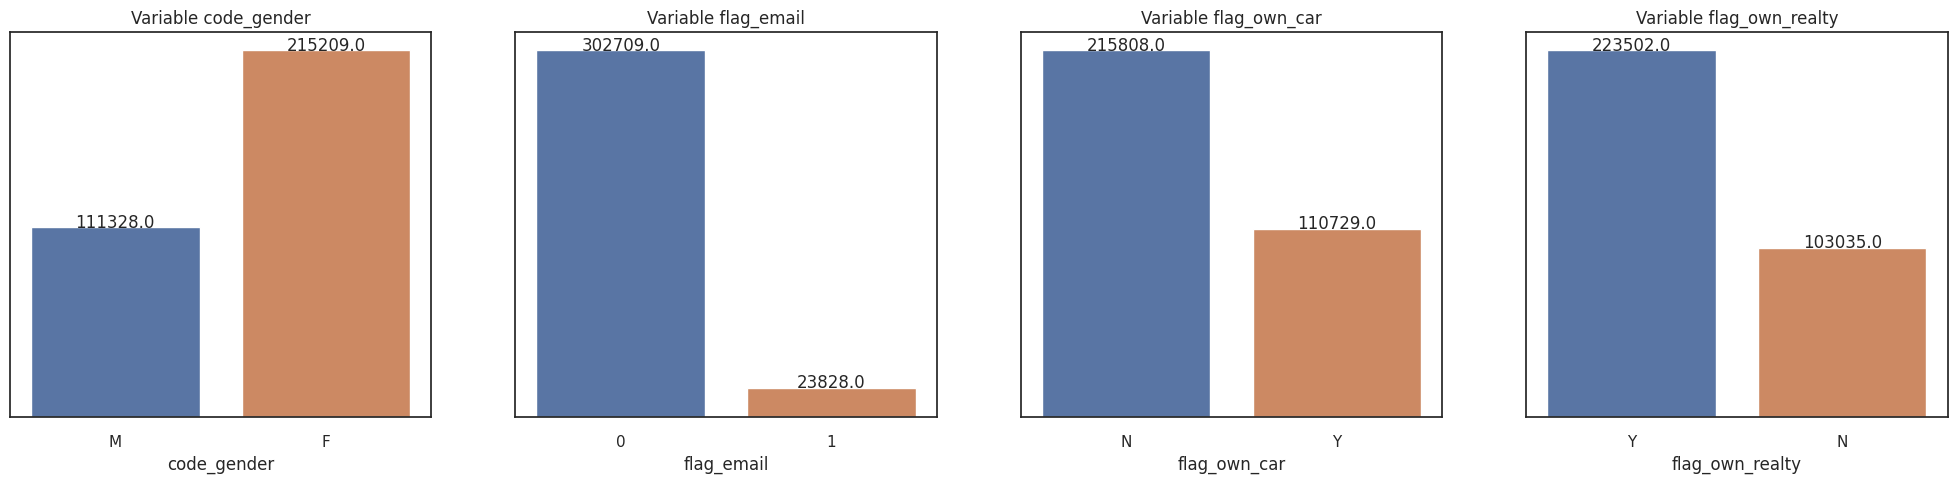

In [ ]:
grafico_barra_cuadruple(df_clean,'code_gender','flag_email','flag_own_car','flag_own_realty')

df_clean.drop('flag_email', axis=1, inplace=True)

## 2.20 Variables: Aplicación a proceso de crédito ('hour_appr_process_start','weekday_appr_process_start')

Se presentan 2 variables categóricas:
1. Hora aproximada de la solicitud de préstamo por parte del cliente.
2. Día hábil en el cual el cliente pide el préstamo.

Estas variables muestran un comportamiento esperado, ya que tienen una mayor frecuencia las horas en que el banco esta abierto al público y los días de la semana tienen la misma frecuencia indistintamente del día, excepto por los fines de semana y horarios no laborales del banco en los que podemoms suponer que las solicitudes son entregadas en linea.

Ambas variables serán eliminadas, ya que cualitativamente no deberían tener incidencia en el comportamiento de pago de un crédito.

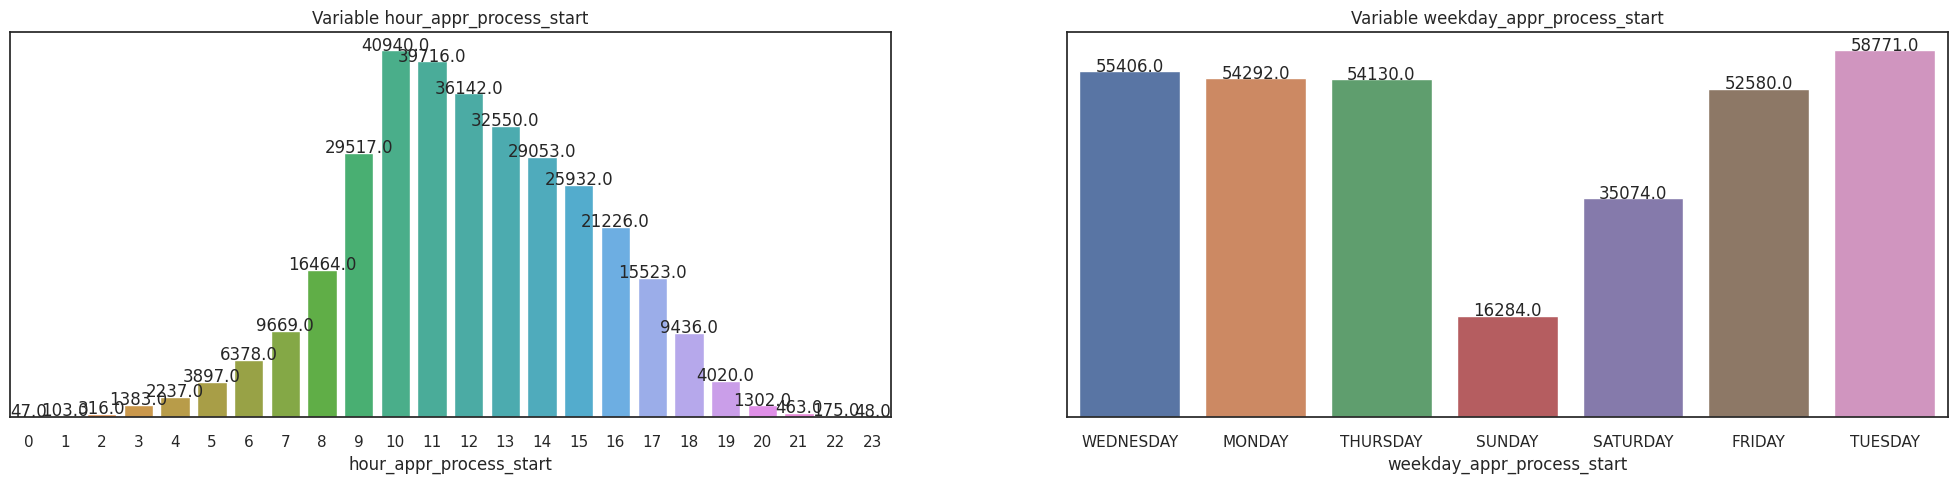

In [ ]:
grafico_barra_doble(df_clean,'hour_appr_process_start','weekday_appr_process_start')

df_clean.drop('hour_appr_process_start', axis=1, inplace=True)
df_clean.drop('weekday_appr_process_start', axis=1, inplace=True)

## 2.21 Variables: Ingresos y acompañamiento ('name_income_type', 'name_type_suite')

Se presentan 2 variables categóricas:

1. Tipo de ingreso por parte del cliente (empresario, asalariado,
postnatal, entre otros)
2. Quien acompaña al cliente cuando fue a solicitar el préstamo.

La variable de acompañante será eliminada por no tener influencia en el comportamiento del pago de un crédito.

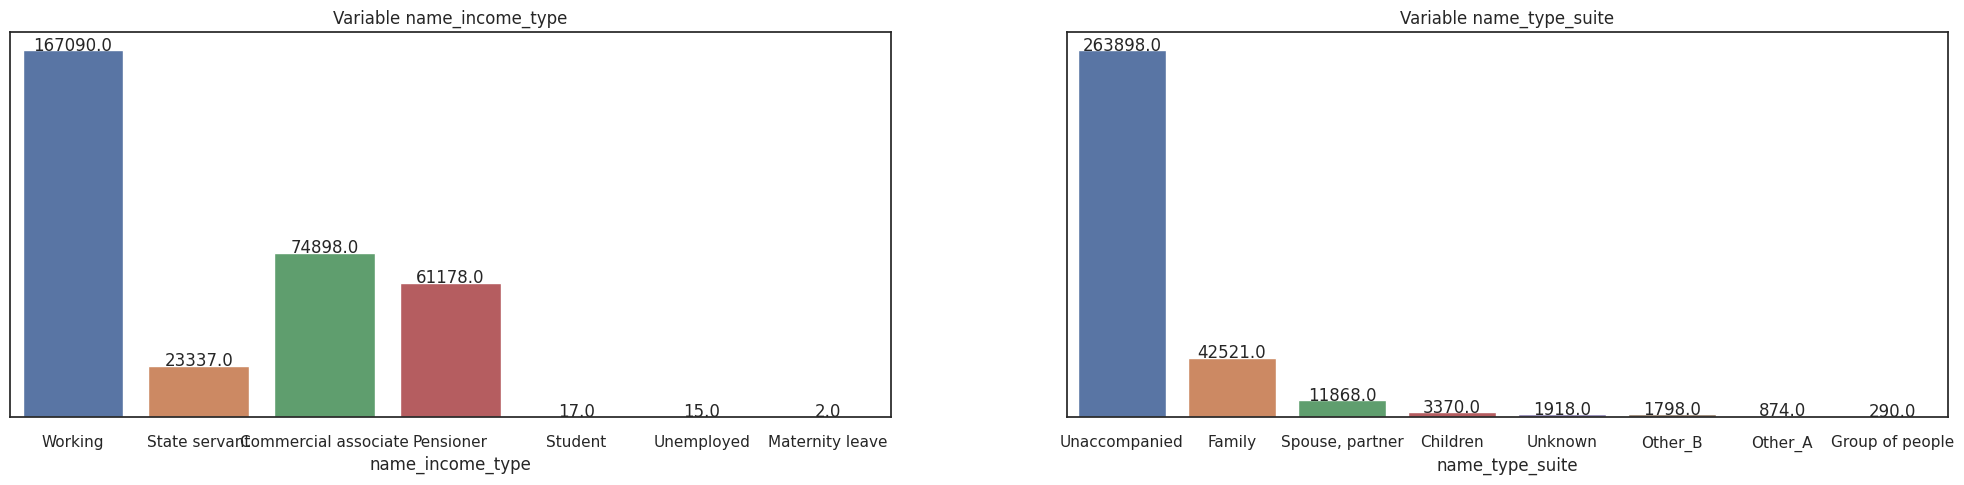

In [ ]:
grafico_barra_doble(df_clean,'name_income_type','name_type_suite')

df_clean.drop('name_type_suite', axis=1, inplace=True)

### 2.21.1 Recodificación: Tipo de Ingreso  (name_income_type)

Dada la alta cantidad de valores únicos dentro de la variable 'name_income_type' se agrupan los valores en las categorias: working, commercial, others, government.
De esta forma podemos observar que la mayoria de los clientes que solicitan créditos son los del tipo working.

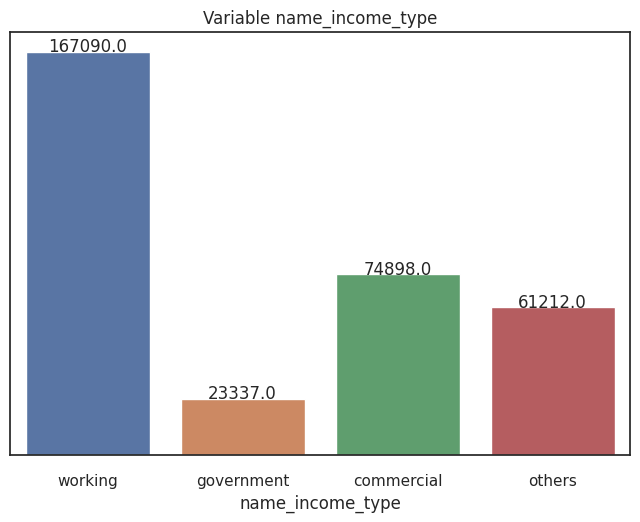

,%
Regitros,
working,51.17
commercial,22.94
others,18.75
government,7.15


In [ ]:
grupo_1_1=['Working']
grupo_1_2=['Commercial associate']
grupo_1_3=['Pensioner', 'Maternity leave', 'Student','Unemployed']
grupo_1_4=['State servant']

df_clean['name_income_type'] = df_clean['name_income_type'].replace(grupo_1_1,'working')
df_clean['name_income_type'] = df_clean['name_income_type'].replace(grupo_1_2,'commercial')
df_clean['name_income_type'] = df_clean['name_income_type'].replace(grupo_1_3,'others')
df_clean['name_income_type'] = df_clean['name_income_type'].replace(grupo_1_4,'government')

grafico_barra(df_clean,'name_income_type','Variable name_income_type')

## 2.22 Variables: Situación Familiar y Académica del cliente

Se presentan 2 variables categóricas:
1. Máximo nivel educacional por parte del cliente (name_education_type)
2. Situación familiar del cliente (name_family_status).


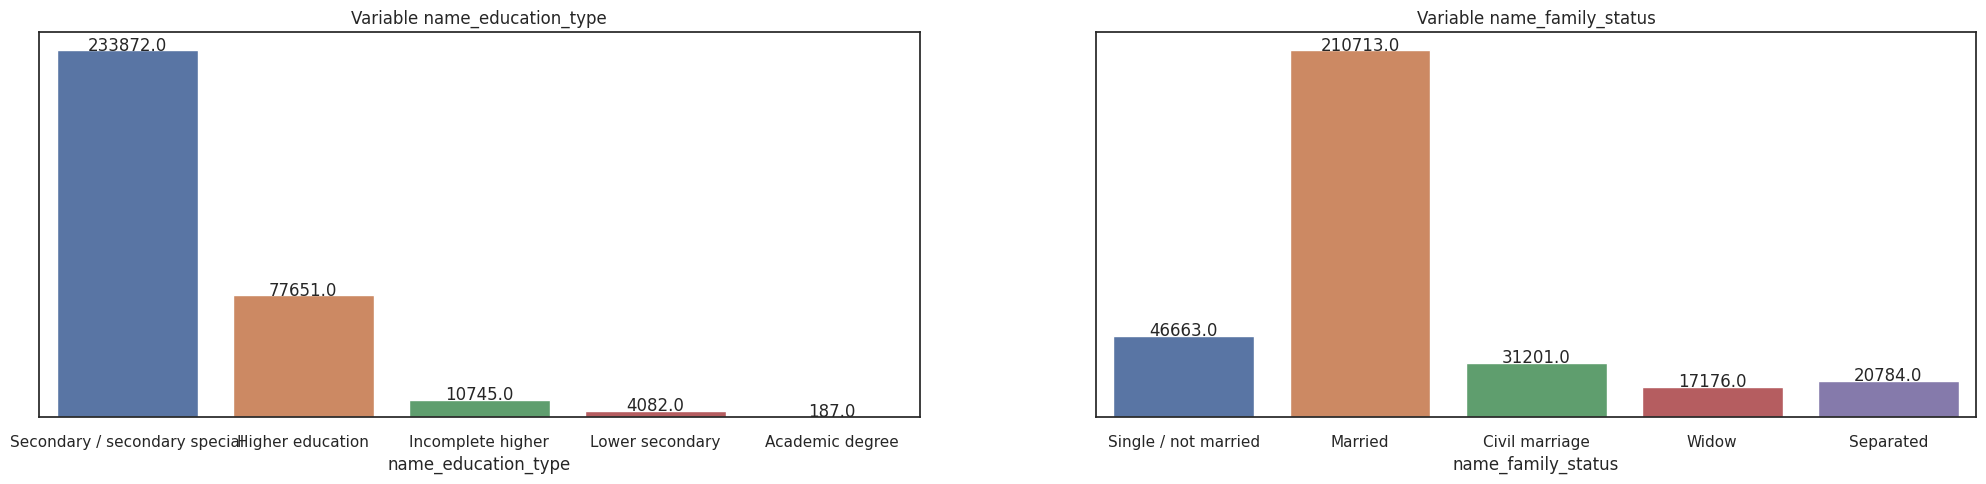

In [ ]:
grafico_barra_doble(df_clean,'name_education_type','name_family_status')

## 2.23 Variables: Hogar y trabajo

Se presentan 3 variables categóricas:
1. Situación habitacional del cliente (name_housing_type).
2. Profesión del cliente (occupation_type).
3. Tipo de organización donde trabaja el cliente (organization_type).

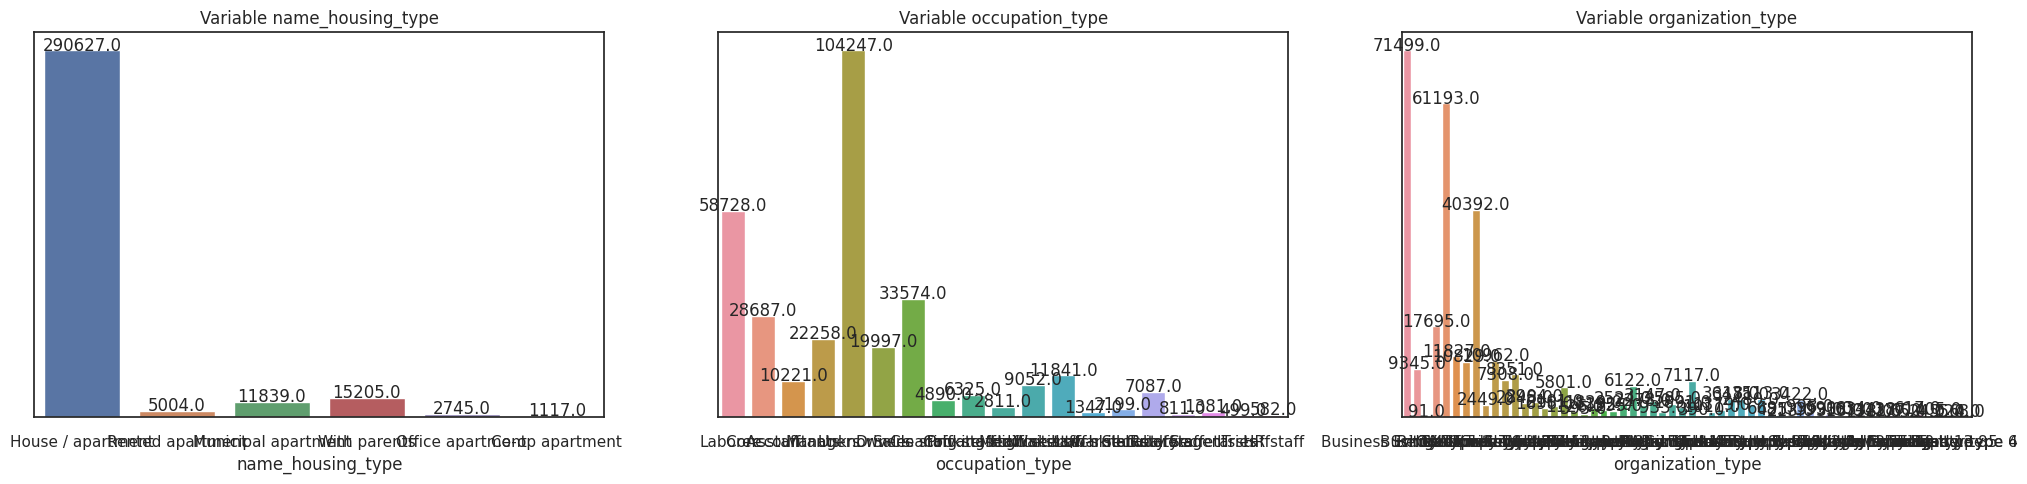

In [ ]:
grafico_barra_triple(df_clean,'name_housing_type','occupation_type','organization_type')

### 2.23.1 Recodificación: Situación habitacional

Dada la alta cantidad de valores únicos dentro de la variable se agrupan los valores.

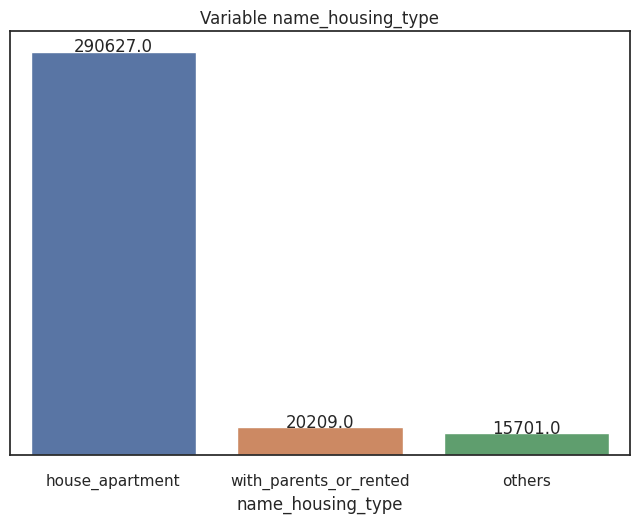

,%
Regitros,
house_apartment,89.00
with_parents_or_rented,6.19
others,4.81


In [ ]:
grupo_2_1=['With parents','Rented apartment']
grupo_2_2=['House / apartment']
grupo_2_3=['Municipal apartment', 'Office apartment', 'Co-op apartment']

df_clean['name_housing_type'] = df_clean['name_housing_type'].replace(grupo_2_1,'with_parents_or_rented')
df_clean['name_housing_type'] = df_clean['name_housing_type'].replace(grupo_2_2,'house_apartment')
df_clean['name_housing_type'] = df_clean['name_housing_type'].replace(grupo_2_3,'others')

grafico_barra(df_clean,'name_housing_type','Variable name_housing_type')

### 2.23.2 Recodificación: Profesión

Dada la alta cantidad de valores únicos dentro de la variable se agrupan los valores.

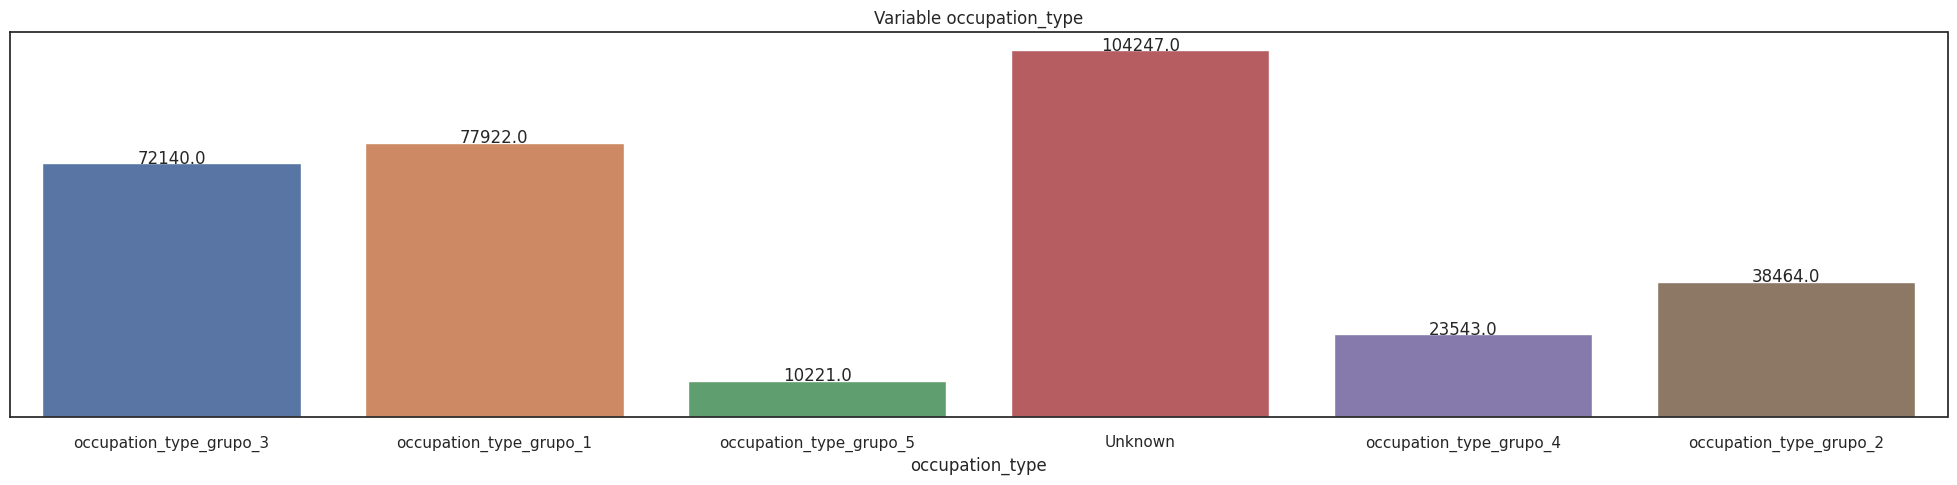

,%
Regitros,
Unknown,31.93
occupation_type_grupo_1,23.86
occupation_type_grupo_3,22.09
occupation_type_grupo_2,11.78
occupation_type_grupo_4,7.21
occupation_type_grupo_5,3.13


In [ ]:
grupo_3_1 = ['Core staff','High skill tech staff','HR staff','IT staff','Managers','Medicine staff','Private service staff','Realty agents','Secretaries']
grupo_3_2 = ['Cleaning staff','Sales staff']
grupo_3_3 = ['Cooking staff','Laborers','Security staff']
grupo_3_4 = ['Drivers','Low-skill Laborers','Waiters/barmen staff']
grupo_3_5 = ['Accountants']

df_clean['occupation_type'] = df_clean['occupation_type'].replace(grupo_3_1,'occupation_type_grupo_1')
df_clean['occupation_type'] = df_clean['occupation_type'].replace(grupo_3_2,'occupation_type_grupo_2')
df_clean['occupation_type'] = df_clean['occupation_type'].replace(grupo_3_3,'occupation_type_grupo_3')
df_clean['occupation_type'] = df_clean['occupation_type'].replace(grupo_3_4,'occupation_type_grupo_4')
df_clean['occupation_type'] = df_clean['occupation_type'].replace(grupo_3_5,'occupation_type_grupo_5')

plt.figure(figsize=(25,5))
grafico_barra(df_clean,'occupation_type','Variable occupation_type')

### 2.23.3 Recodificación: Tipo de organización

Dada la alta cantidad de valores únicos dentro de la variable se agrupan los valores.

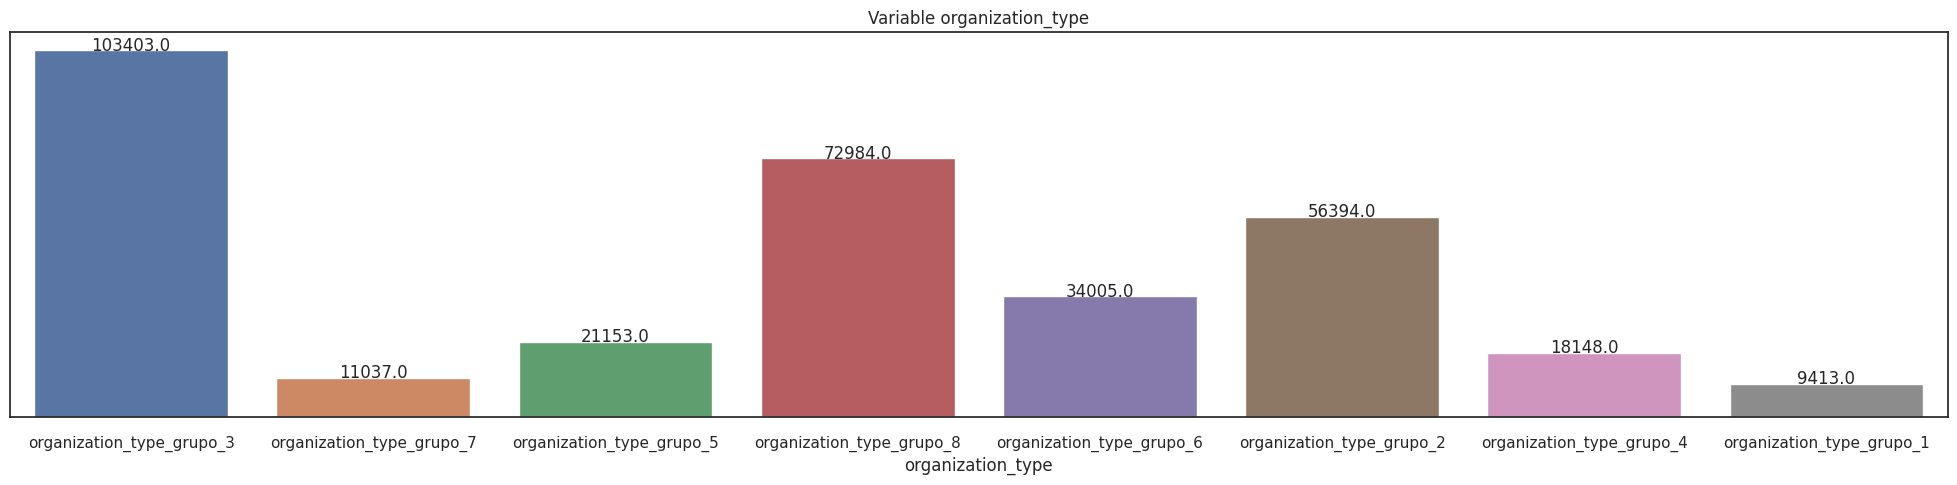

,%
Regitros,
organization_type_grupo_3,31.67
organization_type_grupo_8,22.35
organization_type_grupo_2,17.27
organization_type_grupo_6,10.41
organization_type_grupo_5,6.48
organization_type_grupo_4,5.56
organization_type_grupo_7,3.38
organization_type_grupo_1,2.88


In [ ]:
def extrae_tipo(texto,subtexto=[":","Type"]):
  texto2 = texto
  for st in subtexto:
    n = texto2.count(st)
    if n > 0:
      indice = texto.index(st)
      texto2 = texto[0:indice]
  return(texto2.strip())

df_clean['organization_type'] = df_clean['organization_type'].apply(lambda x: extrae_tipo(x))

grupo_4_1 = ["Construction","Realtor","Restaurant"]
grupo_4_2 = ["Agriculture","Cleaning","Security","Self-employed","Transport"]
grupo_4_3 = ["Business Entity","Trade"]
grupo_4_4 = ["Advertising","Industry","Mobile","Postal"]
grupo_4_5 = ["Housing","Legal Services","Other"]
grupo_4_6 = ["Electricity","Emergency","Government","Kindergarten","Medicine","Services","Telecom"]
grupo_4_7 = ["Hotel","Insurance","Religion","School"]
grupo_4_8 = ["Bank","Culture","Military","Police","Security Ministries","University","XNA"]

df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_1,'organization_type_grupo_1')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_2,'organization_type_grupo_2')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_3,'organization_type_grupo_3')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_4,'organization_type_grupo_4')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_5,'organization_type_grupo_5')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_6,'organization_type_grupo_6')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_7,'organization_type_grupo_7')
df_clean['organization_type'] = df_clean['organization_type'].replace(grupo_4_8,'organization_type_grupo_8')

plt.figure(figsize=(25,5))
grafico_barra(df_clean,'organization_type','Variable organization_type')

## 2.24 Variables: Documentos

Se presentan 3 variables binarias, cada una corresponde al indicador de un documento.
Dada la falta de información relacionada a los documentos estos no serán considerados y las variables eliminadas.

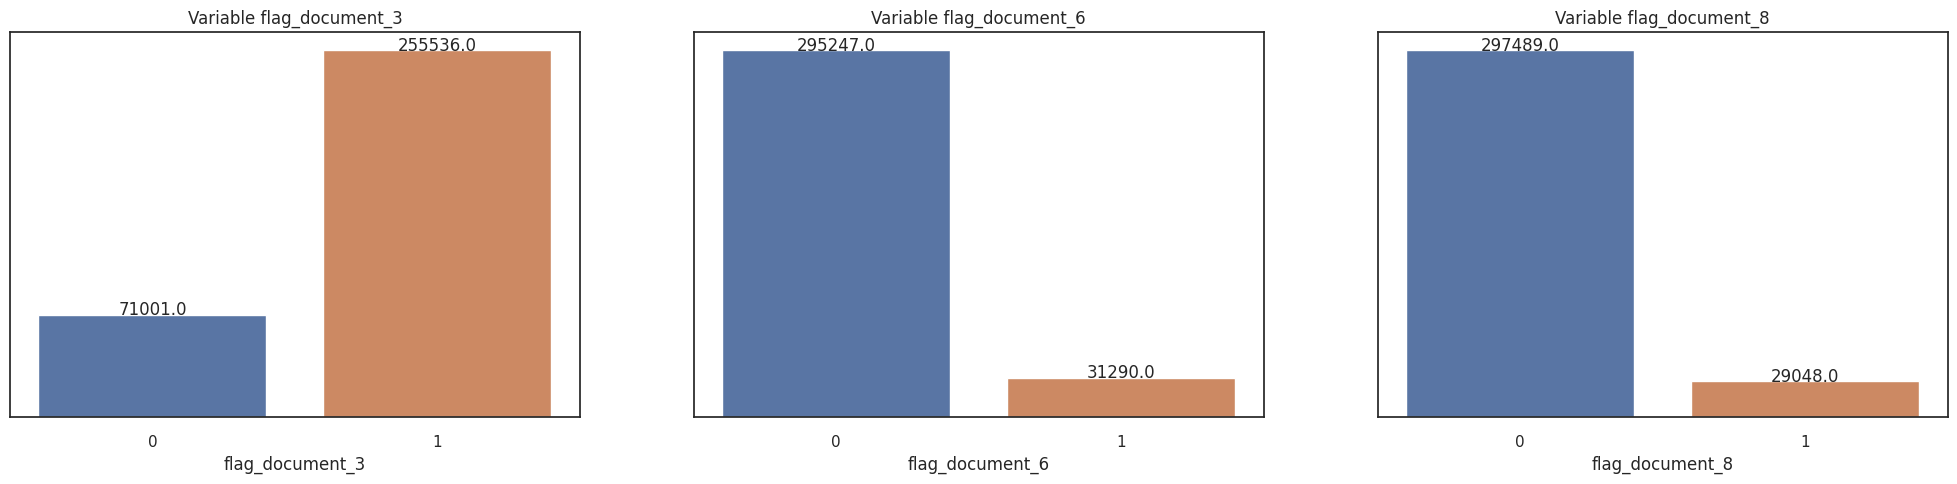

In [ ]:
grafico_barra_triple(df_clean,'flag_document_3','flag_document_6','flag_document_8')

df_clean.drop('flag_document_3', axis=1, inplace=True)
df_clean.drop('flag_document_6', axis=1, inplace=True)
df_clean.drop('flag_document_8', axis=1, inplace=True)

## 2.25 Presentanción de dataset

In [ ]:
# se identifica la forma actual del dataset
forma_dataset(df_clean)

El dataset presenta 326537 registros y 37 variables


In [ ]:
# se identifica la cantidad actual de variables por tipo
tipos_dataset(df_clean)

,Tipos,Cantidad de Variables
0,float64,15
1,int64,12
2,object,10


## 2.26 Análisis bivariado de algunas variables

Ingresos: No existe una gran variación en la distribución entre buenos y malos pagadores según su ingreso.

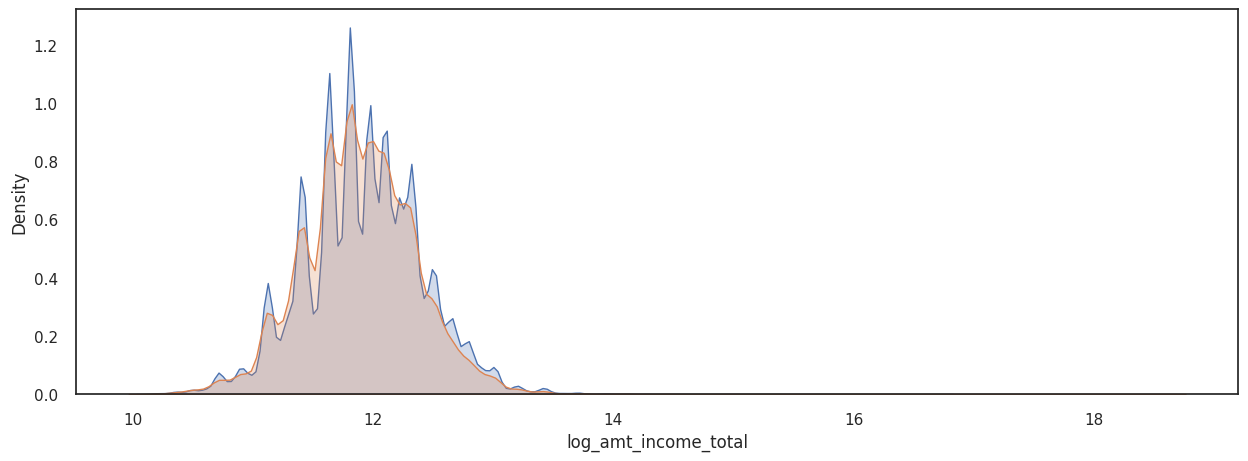

In [ ]:
plt.figure(figsize=(15,5))
ax=sns.kdeplot(data=df_clean[df_clean['target']==0]['log_amt_income_total'], shade=True, legend='Buenos')
ax=sns.kdeplot(data=df_clean[df_clean['target']==1]['log_amt_income_total'], shade=True, legend='Malos')

Días trabajados: El balanceo es similar entre los buenos y malos pagadores con y sin días trabajados.

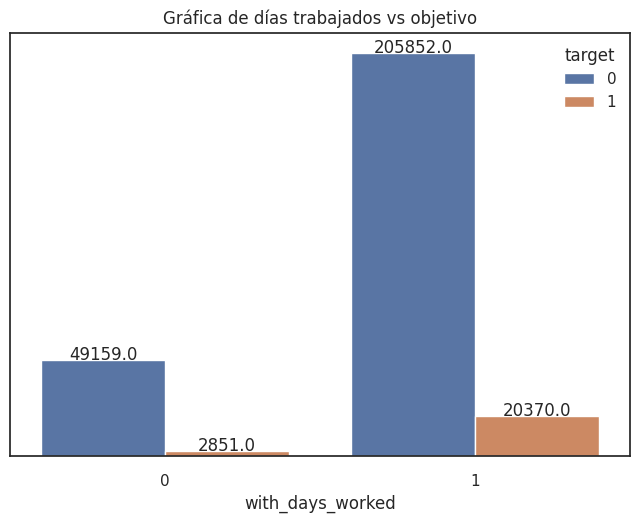

target,0,1,All
with_days_worked,,,
0,94.52,5.48,100.0
1,91.00,9.00,100.0
All,91.65,8.35,100.0


In [ ]:
grafico_barra_hue(df_clean[df_clean['target']!=2],'with_days_worked','target','Gráfica de días trabajados vs objetivo')

Cantidad de familiares: No hay diferencias notorias entre los buenos y malos pagadores según su cantidad de integrantes de la familia.

Text(0.5, 1.0, 'Gráfica de tamaño familiar malos pagadores')

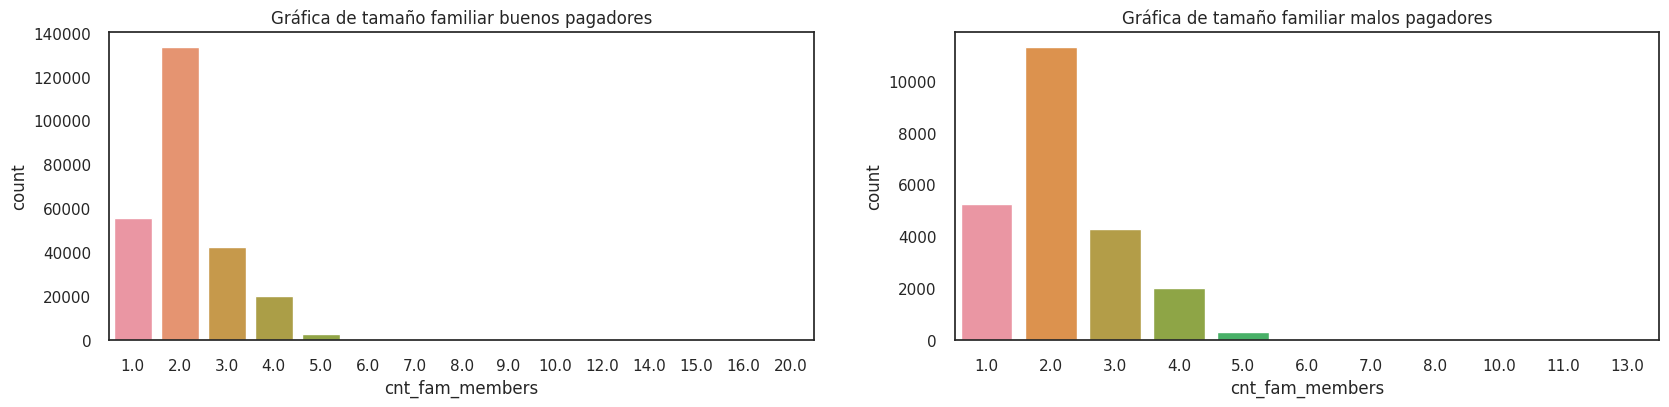

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.countplot(x='cnt_fam_members',data=df_clean[df_clean['target']==0])
plt.title('Gráfica de tamaño familiar buenos pagadores')
plt.subplot(1,2,2)
sns.countplot(x='cnt_fam_members',data=df_clean[df_clean['target']==1])
plt.title('Gráfica de tamaño familiar malos pagadores')

# 3 Análisis de correlaciones

## 3.1 Matriz de correlaciones

Se presenta la matriz de correlaciones para identificar a las variables con mayor correlación.

In [ ]:
def mapa_corr(df):
  plt.figure(figsize=(30,8))
  sns.heatmap(abs(df.corr().round(2)), annot=True, cmap='Reds')

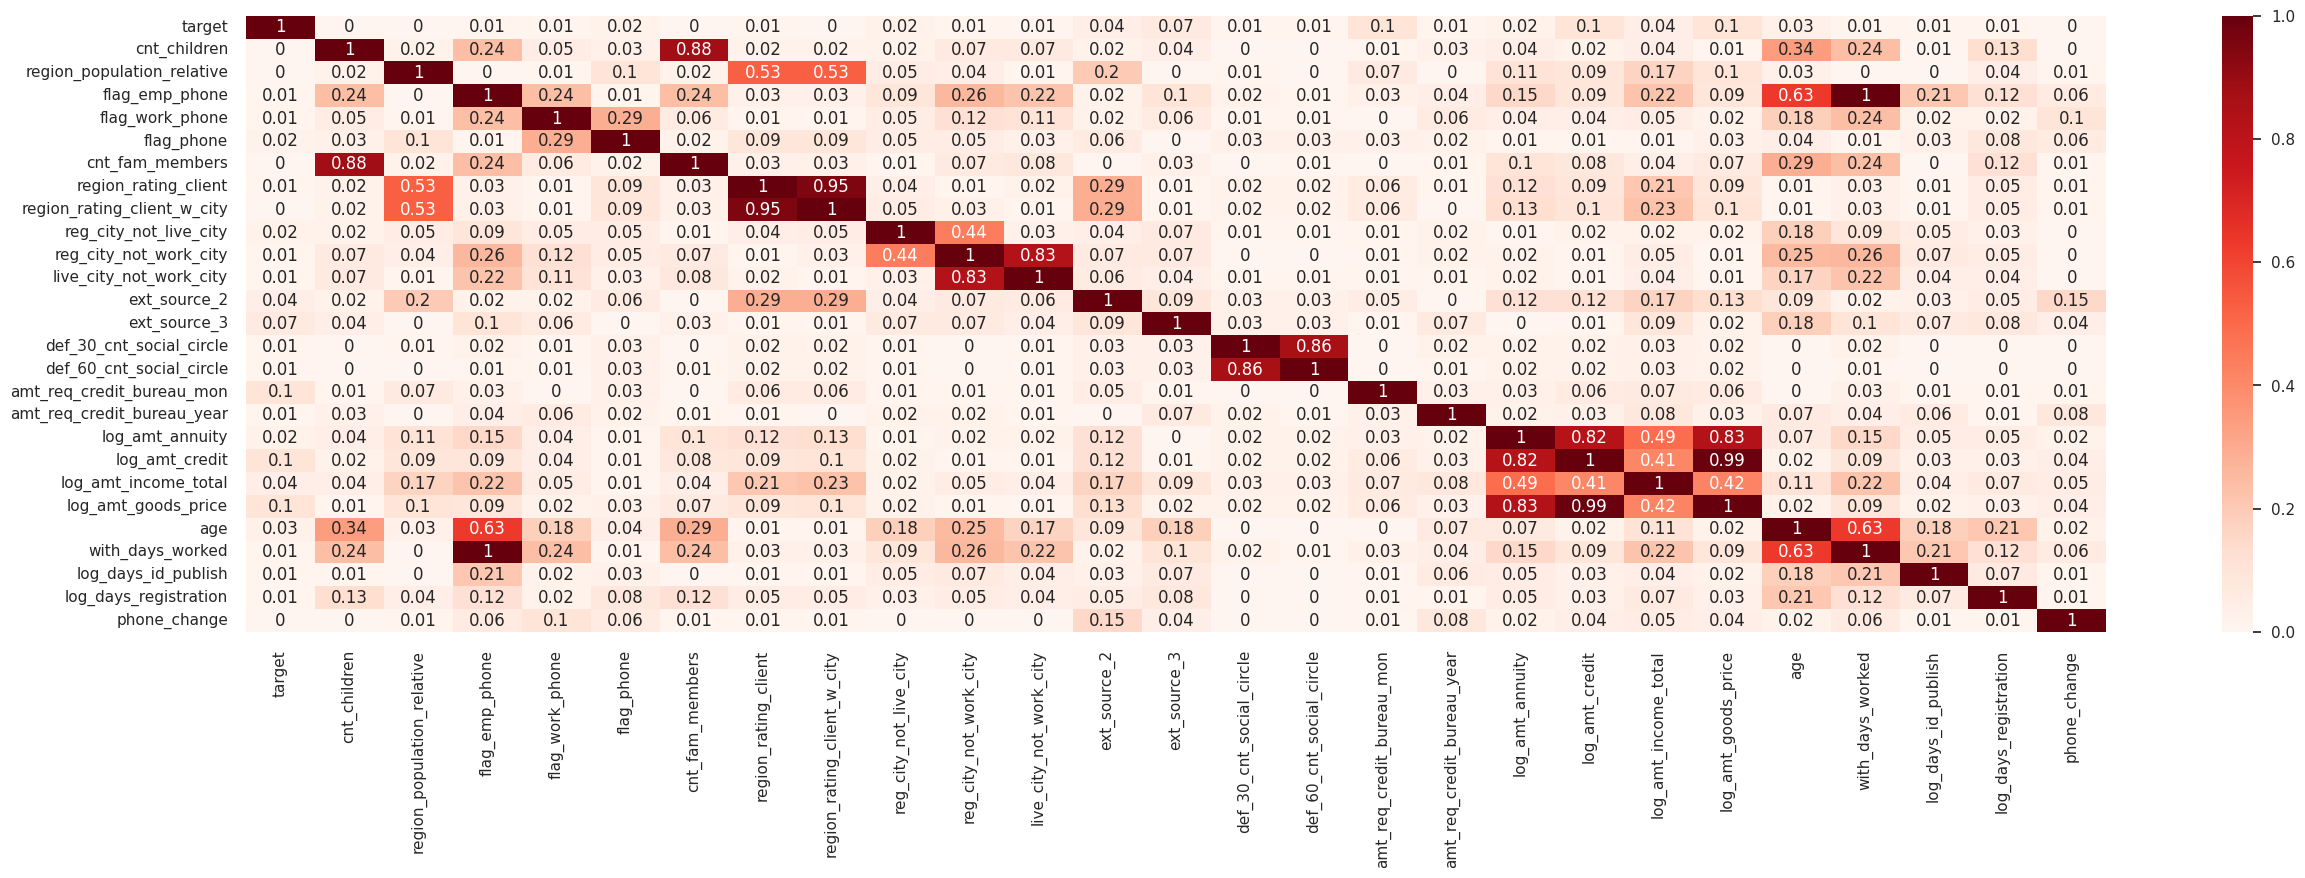

In [ ]:
# se visualiza el mapa de correlación de la variables
mapa_corr(df_clean)

Como podemos observar en el gráfico, nuestra variable target tiene nula correlación con todas las demás variables, esto sin embago, significa que no hay relación lineal más no que carece de algun tipo de relación. Tambien podemos ver que las variables CNT_CHILDREN (Número de hijos) y CNT_FAM_MEMBERS (Número de integrantes de la famila) estan fuertemente correlacionadas positivamente, por lo tanto si una sube, la otra tambien (lo cual era de esperarse debido a que es facil ver su relacion lineal).

## 3.2 Tabla de variables más correlacionadas

Se presenta una tabla con todas las variables con correlación superior al 60% para evaluar su eliminación del dataset.

In [ ]:
def tabla_corr(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1', 'variable_2', 'r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = round(np.abs(corr_mat['r']),4)
    corr_mat.drop('r', axis=1, inplace=True)
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    return corr_mat

In [ ]:
tabla_corr = tabla_corr(df_clean.corr())
tabla_corr_filtrada = tabla_corr[tabla_corr['abs_r']>0.6].copy()
columnas_consideradas = pd.unique(list(tabla_corr_filtrada['variable_1']) + list(tabla_corr_filtrada['variable_2']))
tabla_corr_filtrada

,variable_1,variable_2,abs_r
104,flag_emp_phone,with_days_worked,0.9999
624,with_days_worked,flag_emp_phone,0.9999
534,log_amt_credit,log_amt_goods_price,0.9897
586,log_amt_goods_price,log_amt_credit,0.9897
223,region_rating_client_w_city,region_rating_client,0.9496
197,region_rating_client,region_rating_client_w_city,0.9496
33,cnt_children,cnt_fam_members,0.8787
163,cnt_fam_members,cnt_children,0.8787
419,def_60_cnt_social_circle,def_30_cnt_social_circle,0.8638
393,def_30_cnt_social_circle,def_60_cnt_social_circle,0.8638


## 3.3 Tabla de variables correlacionadas con vector objetivo

Se presenta una tabla con la correlación de variables con vector objetivo evaluar su eliminación del dataset.

In [ ]:
def d_cohen(df):
  df_clean_num = df.select_dtypes(include=['float64', 'int']).drop('target', axis=1)
  columns_numeric = list(df_clean_num)
  target = df['target']
  df_clase_1 = df_clean_num[target == 1]
  df_clase_0 = df_clean_num[target == 0]
  d_de_Cohen = []
  for col in columns_numeric:
    a = df_clase_1[col].mean()
    b = df_clase_0[col].mean()
    std = df_clean_num[col].std()
    d = abs(round((b - a)/std, 2))
    d_de_Cohen.append((col, d))
    d_cohen=pd.DataFrame(d_de_Cohen).sort_values(by=1, ascending=False)
  return d_cohen

In [ ]:
d_cohen(df_clean)

,0,1
11,ext_source_2,0.59
12,ext_source_3,0.58
21,age,0.30
7,region_rating_client_w_city,0.22
6,region_rating_client,0.21
9,reg_city_not_work_city,0.19
2,flag_emp_phone,0.18
22,with_days_worked,0.18
8,reg_city_not_live_city,0.16
23,log_days_id_publish,0.15


## 3.4 Eliminación de variables seleccionadas

A partir de los análisis de correlación presentados se decide la eliminación de 6 variables del dataset.

In [ ]:
# se eliminan las variables que presentan mayor correlación según Pearson y menor correlación según la D de Cohen
df_clean=df_clean.drop(['with_days_worked', 'log_amt_goods_price', 'region_rating_client', 'log_amt_annuity', 'amt_req_credit_bureau_year', 'cnt_fam_members'], axis=1)

In [ ]:
# se identifica la forma actual del dataset
forma_dataset(df_clean)

El dataset presenta 326537 registros y 31 variables


In [ ]:
# se identifica la cantidad actual de variables por tipo
tipos_dataset(df_clean)

,Tipos,Cantidad de Variables
0,float64,11
1,int64,10
2,object,10


In [ ]:
def funnel_datos_final(original,filtrado,limpio,final):
  columnas_muestra=['Index','Dataset original','Dataset filtrado','Dataset limpio','Dataset final']
  index=['Variables','Registros','% Datos']
  datos_originales=[len(original.columns),len(original),round(len(original)/len(original),4)*100]
  datos_filtrados=[len(filtrado.columns),len(filtrado),round(len(filtrado)/len(original),4)*100]
  datos_limpios=[len(limpio.columns),len(limpio),round(len(limpio)/len(original),4)*100]
  datos_final=[len(final.columns),len(final),round(len(final)/len(original),4)*100]
  return pd.DataFrame(list(zip(index,datos_originales,datos_filtrados,datos_limpios,datos_final)),columns=[columnas_muestra])

In [ ]:
funnel_datos_final(df_inicial_copy,df_cash_copy,df_clean_copy,df_clean)

,Index,Dataset original,Dataset filtrado,Dataset limpio,Dataset final
0,Variables,122.0,121.00,50.00,31.00
1,Registros,356255.0,326537.00,326537.00,326537.00
2,% Datos,100.0,91.66,91.66,91.66


# 4 Feature engineering

## 4.1 Preprocesamiento de datos.

Se crea una copia del dataset como resguardo y se convierten variables categóricas en variables binarias para su procesamiento.

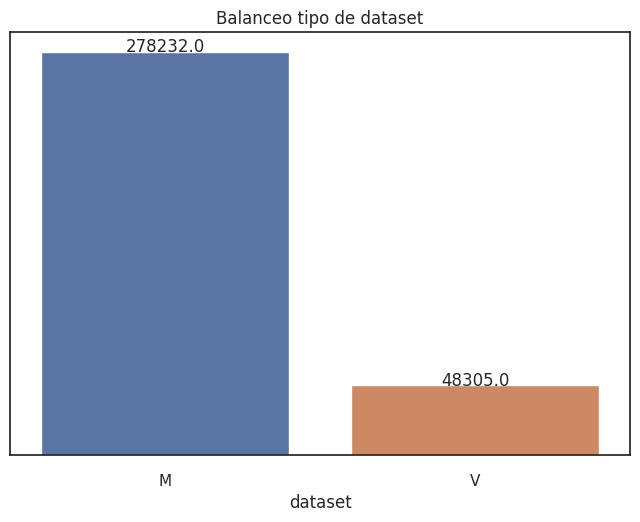

,%
Regitros,
M,85.21
V,14.79


In [ ]:
# revisamos el balanceo de los dataset después de la limpieza
grafico_barra(df_clean,'dataset','Balanceo tipo de dataset')

In [ ]:
# se crea una copia del dataset actual previo a su premodelamiento
df_clean_2=df_clean.copy()

In [ ]:
# de ahora en adelante se trabajará solo con el dataset de modelamiento
# posterior a la elección de algunos modelos se incorporará al análisis el dataset de validación
# se crea una lista solo con las variables categóricas
columnas_object=[]
for index,(colname, serie) in enumerate(df_clean.iteritems()):
    if serie.dtype=='object':
        columnas_object.append(colname)
# se binarizan las variables categóricas
for i in columnas_object:
    df_clean=pd.concat([df_clean, pd.get_dummies(df_clean[i], drop_first=True, prefix=i)], axis=1).drop(columns=i)
# se identifica la cantidad actual de variables por tipo
tipos_dataset(df_clean)

,Tipos,Cantidad de Variables
0,uint8,29
1,float64,11
2,int64,10


In [ ]:
# se visualiza la información del dataset final para modelamiento
info_dataset(df_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326537 entries, 0 to 356254
Data columns (total 50 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   target                                             326537 non-null  int64  
 1   cnt_children                                       326537 non-null  int64  
 2   region_population_relative                         326537 non-null  float64
 3   flag_emp_phone                                     326537 non-null  int64  
 4   flag_work_phone                                    326537 non-null  int64  
 5   flag_phone                                         326537 non-null  int64  
 6   region_rating_client_w_city                        326537 non-null  int64  
 7   reg_city_not_live_city                             326537 non-null  int64  
 8   reg_city_not_work_city                             326537 non-null  int64 

In [ ]:
# separamos los dataset ya limpios nuevamente
df_clean_model=df_clean[df_clean['dataset_V']==0]
df_clean_valid=df_clean[df_clean['dataset_V']==1]
# se elimina la columna dataset de cada uno al convertirse en valor único
df_clean_model=df_clean_model.drop('dataset_V', axis=1)
df_clean_valid=df_clean_valid.drop('dataset_V', axis=1)
# se elimina la columna target creada con valor 2 del dataset de validación
df_clean_valid=df_clean_valid.drop('target', axis=1)

In [ ]:
# se identifica la forma actual del dataset de modelamiento
forma_dataset(df_clean_model)

El dataset presenta 278232 registros y 49 variables


In [ ]:
# se identifica la forma actual del dataset de validación
forma_dataset(df_clean_valid)

El dataset presenta 48305 registros y 48 variables


In [ ]:
# se crea una copia del dataset actual previo a su premodelamiento
df_clean_model_2=df_clean_model.copy()
df_clean_valid_2=df_clean_valid.copy()

# 5 Premodelamiento

Como comentamos antes, nuestro dataset esta desbalanceado entre los clientes buenos y malos. Si implementamos un modelo con esta situación nos dara una exactitud muy alta debido a que los casos malo a indentificar son muy pocos (8.3% de los casos totales). Esto significaria que el modelo tendria muy poca información de los malos y puesto en producción podria identificar a clientes malos como buenos con mucha frecuencia dejando obsoleto toda el objetivo de este proyecto.

Para balancear nuestros datos, haremos un sobre-muestreo de nuestra clase minoritaria (clientes malos), crearemos información sintentica basandonos en esos datos para asi tener una proporción balanceada en ambas clases

## 5.1 Separando y escalando en conjuntos de entrenamiento y validación

In [ ]:
# dividimos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df_clean_model.drop(['target', 'ext_source_2', 'ext_source_3'], axis=1),
                                                    df_clean_model['target'],  test_size=0.33, random_state=23679)

Existen atributos con un rango de valores muy grande. Dado ello, escalamos los datos para que no se introduzcan sesgos por dimensionalidad.

In [ ]:
# estandarizamos matriz de atributos
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## 5.2 Undersampling para realizar un balance

In [ ]:
def tabla_comp_train(lista_metodo,lista_X_train,lista_y_train):
    """Recibe una lista de entrenamientos y objetivos (X_train,y_train) para armar resumen"""
    n_reg_lista = []
    n_target_1_lista = []

    for X_train in lista_X_train:
        n_reg = len(X_train)
        n_reg_lista.append(n_reg)

    for y_train in lista_y_train:
        y_train = list(y_train)
        n_target_1 = sum(y_train)
        n_target_1_lista.append(n_target_1)

    tabla = pd.DataFrame({'Base':lista_metodo, 'n_registros': n_reg_lista, 'n_target_1': n_target_1_lista})
    tabla['% target 1'] = round(tabla['n_target_1']/tabla['n_registros']*100,2)
    tabla = tabla.set_index('Base')
    return tabla

In [ ]:
# el parametro sampling strategy se define como "not minority" para ejecutar un under sampling
undersampler = RandomUnderSampler(random_state=42, sampling_strategy='not minority')
X_train_s, y_train_s = undersampler.fit_resample(X_train_std, y_train)

# para resumen
metodos = ['Original','Balanceada (Subsampling)']
lista_X_train = [X_train_std,X_train_s]
lista_y_train = [y_train,y_train_s]

print("Resumen Bases consideradas:")

tabla_comp_train(metodos,lista_X_train,lista_y_train)

Resumen Bases consideradas:


,n_registros,n_target_1,% target 1
Base,,,
Original,186415,15558,8.35
Balanceada (Subsampling),31116,15558,50.00




*   Una vez generadas las bases de entrenamiento se obtiene una base con 186.415 registros, correspondiente al 70% de la data original, la cual mantiene la distribución de target de la data original, y una base balanceada, con 31.116 registros, con la distribución de target balanceada (50% clase 0 y 50% clase 1).



# 6 Modelamiento

Testeamos nuestro conjunto de datos en modelos predictivos.

## 6.1 Logistic Regression

In [ ]:
# generamos una instancia del modelo
model_logistic = LogisticRegression(penalty='l2', random_state=4392).fit(X_train_s, y_train_s)

In [ ]:
# predecimos
y_pred_log = model_logistic.predict(X_test_std)
y_pred_prob_log = model_logistic.predict_proba(X_test_std)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.60      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.61      0.48     91817
weighted avg       0.88      0.62      0.70     91817



In [ ]:
def feature_importance_reg_log(modelo,df,var_obj = 'target'):
    importance = modelo.coef_[0]
    features = list(df.drop(columns = var_obj).columns)
    df_feat_import = pd.DataFrame({'Variable':features, 'Importancia': importance})
    df_feat_import['Importancia_abs'] = abs(df_feat_import['Importancia'])
    df_feat_import = df_feat_import.sort_values(by = 'Importancia_abs', ascending = False)
    return df_feat_import

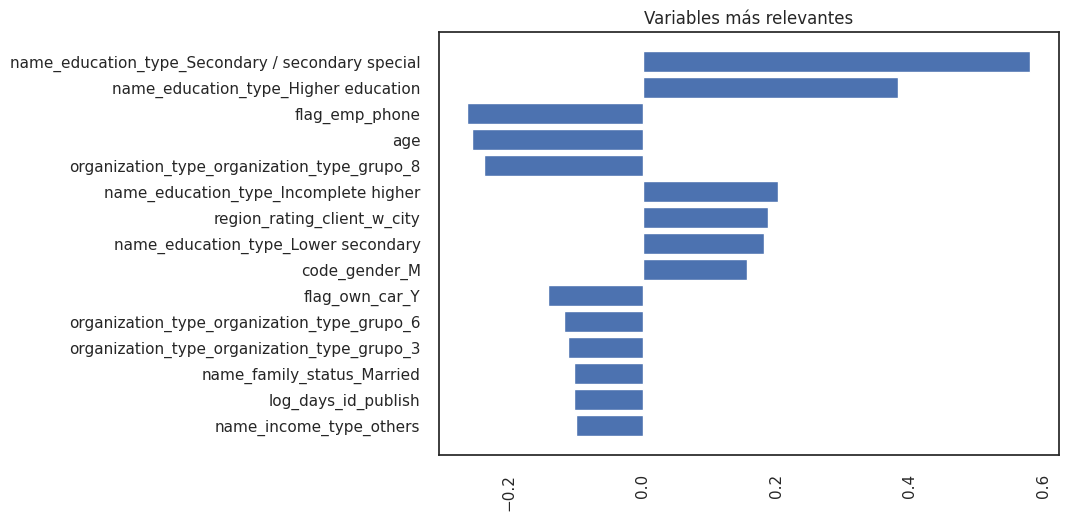

In [ ]:
df_importancias = feature_importance_reg_log(model_logistic, df_clean_model.drop(['ext_source_2', 'ext_source_3'], axis=1))
df_importancias = df_importancias.reset_index()
df_importancias_15 = df_importancias.loc[:14,]
df_importancias_15 = df_importancias_15.sort_values(by='Importancia_abs')
plt.barh(df_importancias_15['Variable'],df_importancias_15['Importancia'])
plt.xticks(rotation = 90);
plt.title("Variables más relevantes");

## 6.2 Random Forest Classifier

In [ ]:
# generamos una instancia del modelo
model_random_forest = RandomForestClassifier(max_depth=5, max_features='log2', random_state=4392).fit(X_train_s, y_train_s)

In [ ]:
# predecimos
y_pred_rf = model_random_forest.predict(X_test_std)
y_pred_prob_rf = model_random_forest.predict_proba(X_test_std)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.57      0.71     84154
           1       0.12      0.65      0.20      7663

    accuracy                           0.57     91817
   macro avg       0.53      0.61      0.46     91817
weighted avg       0.88      0.57      0.67     91817



In [ ]:
# Implementamos el modelo con Random Forest
max_depth = np.linspace(1, 20, 5, dtype=int)
n_estimators = np.linspace(50,10,5, dtype=int)
max_features = ['auto', 'sqrt', 'log2']
# Instanciamos el modelo y lo entrenamos
rfModel = GridSearchCV(RandomForestClassifier(random_state=4392, oob_score=True), {'max_depth': max_depth, 'n_estimators': n_estimators, 'max_features': max_features}, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1).fit(X_train_s, y_train_s)


Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Best parameters: ', rfModel.best_params_)
print(classification_report(y_test, rfModel.predict(X_test_std)))

Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.61      0.21      7663

    accuracy                           0.61     91817
   macro avg       0.54      0.61      0.48     91817
weighted avg       0.88      0.61      0.70     91817



## 6.3 Gradient Boosting

In [ ]:
# generamos una instancia del modelo
model_gboost = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.01, subsample=0.5, random_state=4392).fit(X_train_s, y_train_s)

In [ ]:
# predecimos
y_pred_gb = model_gboost.predict(X_test_std)
y_pred_prob_gb = model_gboost.predict_proba(X_test_std)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.94      0.60      0.74     84154
           1       0.12      0.61      0.20      7663

    accuracy                           0.61     91817
   macro avg       0.53      0.61      0.47     91817
weighted avg       0.88      0.61      0.69     91817



In [ ]:
# Definimos los hiperparámetros para el modelo de GradientBoost
learning_rate = [0.1, 0.3, 0.1]
max_depth = np.linspace(1, 10, 3, dtype=int)
subsample = [0.3, 0.5, 1]
max_features = [None, 'sqrt', 'log2']
# Definimos la busqueda de grilla
gbModel = GridSearchCV(GradientBoostingClassifier(random_state=4392, n_estimators=100, n_iter_no_change=50, validation_fraction=0.2), {'learning_rate': learning_rate, 'max_depth': max_depth, 'subsample': subsample, 'max_features': max_features}, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1).fit(X_train_s, y_train_s)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Best parameters: ', gbModel.best_params_)
print(classification_report(y_test, gbModel.predict(X_test_std)))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'subsample': 1}
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.61      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.62      0.48     91817
weighted avg       0.88      0.62      0.71     91817



## 6.4 AdaBoostClassifier

In [ ]:
# #Creamos el modelo
model_abc =AdaBoostClassifier(n_estimators=1, base_estimator=svc,learning_rate=1, random_state = 4392).fit(X_train_s, y_train_s)

In [ ]:
# predecimos
y_pred_abc = model_abc.predict(X_test_std)
y_pred_prob_abc = model_abc.predict_proba(X_test_std)[:, 1]

In [ ]:
### Resultados
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.95      0.57      0.71     84154
           1       0.12      0.63      0.20      7663

    accuracy                           0.58     91817
   macro avg       0.53      0.60      0.46     91817
weighted avg       0.88      0.58      0.67     91817



In [ ]:
learning_rate = [0.1, 0.5, 0.1]
subsample = [0.1, 0.5, 1]
max_features = [None, 'sqrt', 'log2']
n_estimators = [10, 20, 50, 70]
# Definimos la busqueda de grilla
adaModel = GridSearchCV(AdaBoostClassifier(random_state=4392, n_estimators=1), {'learning_rate': learning_rate, 'n_estimators': n_estimators}, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1).fit(X_train_s, y_train_s)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Best parameters: ', adaModel.best_params_)
print(classification_report(y_test, adaModel.predict(X_test_std)))

Best parameters:  {'learning_rate': 0.5, 'n_estimators': 70}
              precision    recall  f1-score   support

           0       0.95      0.61      0.75     84154
           1       0.13      0.62      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.62      0.48     91817
weighted avg       0.88      0.62      0.70     91817



# 7 Comparación modelos entrenados

## 7.1. Graficamos el cross validation score de cada modelo

In [ ]:
# definimos una lista: nombre, modelo a evaluar (la idea es reemplazar despues con los modelos que vimos anteriormente)
models = []
models.append(('LR', model_logistic))
models.append(('RF', rfModel))
models.append(('GB', gbModel))
models.append(('AD', adaModel))

In [ ]:
# definimos estructuras para guardar resultados y nombres de modelos
results = []
names = []

# obtenemos el cross_val_score (cross validation score) para cada modelo
for name, model in models:
	kfold = model_selection.KFold(n_splits=3)
	cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.916530 (0.002408)
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
RF: 0.916541 (0.002422)
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
GB: 0.916530 (0.002434)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
AD: 0.916541 (0.002422)


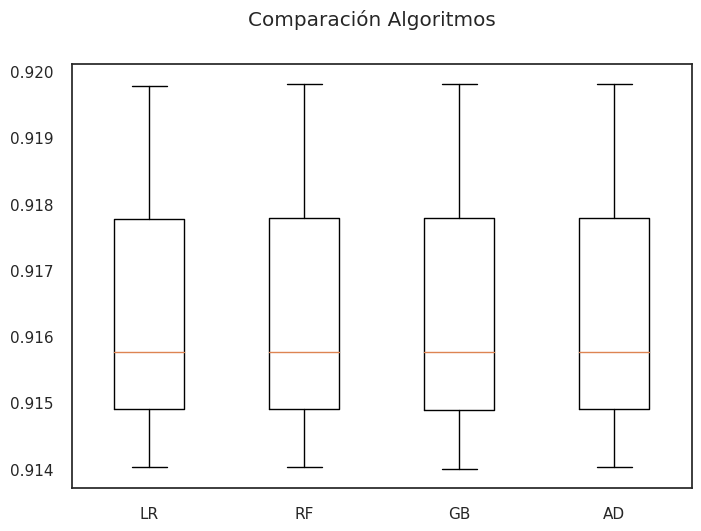

In [ ]:
# comparamos los resultados del cross_val_score mediante un boxplot
fig = plt.figure()
fig.suptitle('Comparación Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

A partir de los gráficos de caja y bigote, que comparan el accuracy de los modelos entrenados a partir del Cross Validation Score; identificamos que el mejor modelo predictivo corresponde al Random Forest Classifier, con un cross validation score (accuracy promedio) de 92%. Sin embargo, los otros modelos entrenados presentan un desempeño similar, por lo tanto, el mejor modelo será definido considerando también otras métricas como aquellas mostradas a continuación.

## 7.2. Visualización curvas ROC

In [ ]:
roc_dict = {'Logistic Regression': y_pred_log,'Random Forest': rfModel.predict(X_test_std),'Gradient Boosting': gbModel.predict(X_test_std),'Ada Boost': adaModel.predict(X_test_std)}

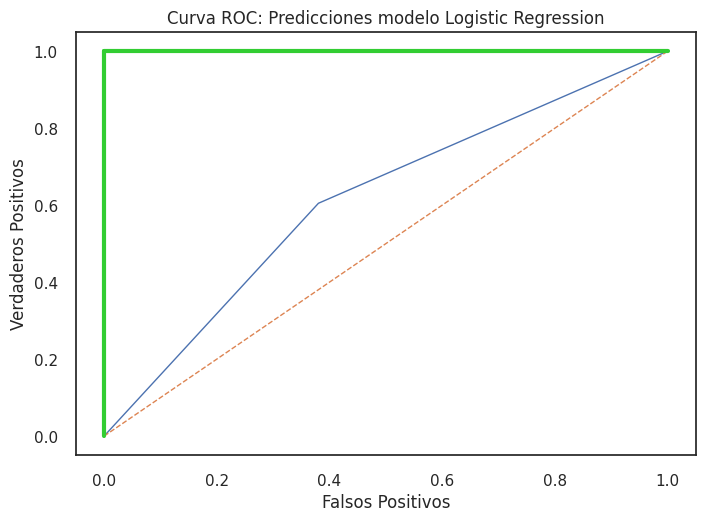

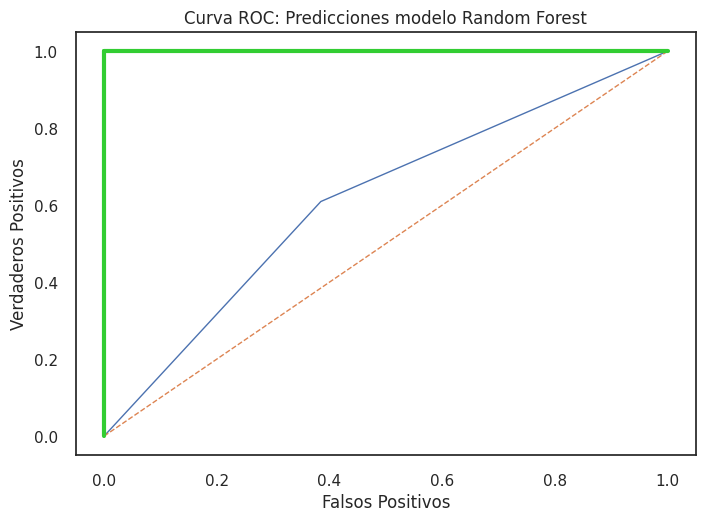

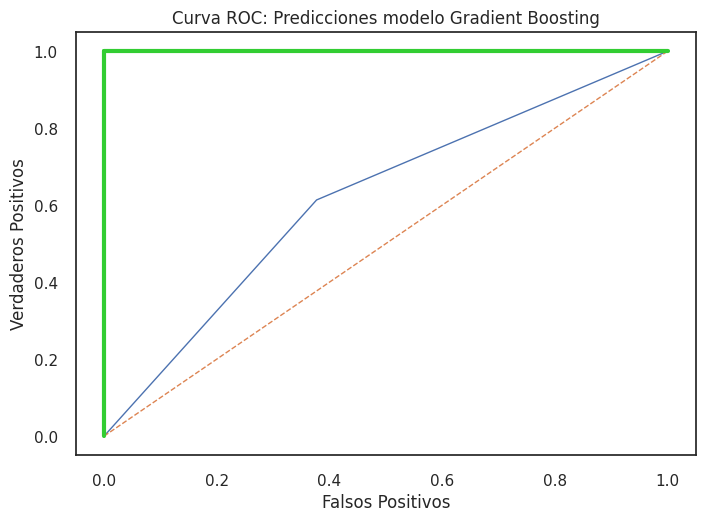

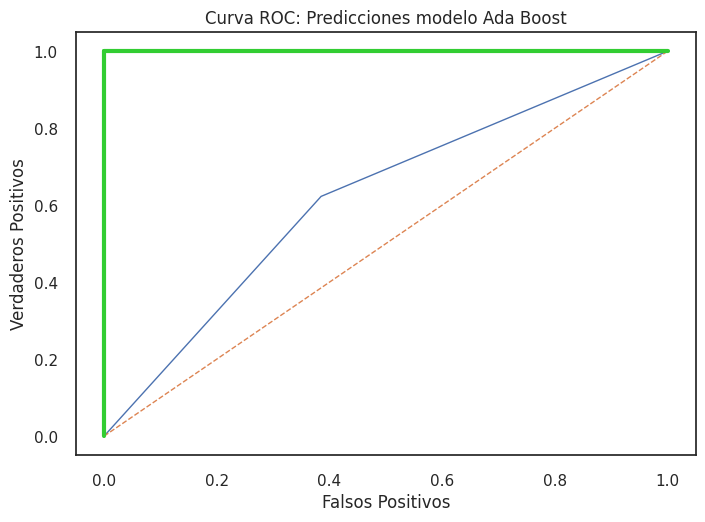

In [ ]:
# iteramos sobre las predicciones de cada modelo y graficamos curvas ROC
for model_name_, y_hat in roc_dict.items():
  # curva roc
  false_positive, true_positive, threshold = roc_curve(y_test, y_hat)
  # grafico roc
  plt.title(f'Curva ROC: Predicciones modelo {model_name_}')
  plt.plot(false_positive, true_positive, lw=1)
  plt.plot([0, 1], ls="--", lw=1)
  plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1], c='limegreen', lw=3)
  plt.ylabel('Verdaderos Positivos')
  plt.xlabel('Falsos Positivos')
  plt.show()

## 7.3 Visualizamos de forma continua el classification report de los modelos entrenados

In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Logistic Regression')
print(classification_report(y_test, y_pred_log))

Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.60      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.61      0.48     91817
weighted avg       0.88      0.62      0.70     91817



In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Random Forest Classifier')
print()
print('Best parameters: ', rfModel.best_params_)
print(classification_report(y_test, rfModel.predict(X_test_std)))

Random Forest Classifier

Best parameters:  {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.61      0.21      7663

    accuracy                           0.61     91817
   macro avg       0.54      0.61      0.48     91817
weighted avg       0.88      0.61      0.70     91817



In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Gradient Boosting Classifier')
print()
print('Best parameters: ', gbModel.best_params_)
print(classification_report(y_test, gbModel.predict(X_test_std)))

Gradient Boosting Classifier

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'subsample': 1}
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     84154
           1       0.13      0.61      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.62      0.48     91817
weighted avg       0.88      0.62      0.71     91817



In [ ]:
# Notificamos los mejores hiperámetros y las métricas
print('Best parameters: ', adaModel.best_params_)
print(classification_report(y_test, adaModel.predict(X_test_std)))

Best parameters:  {'learning_rate': 0.5, 'n_estimators': 70}
              precision    recall  f1-score   support

           0       0.95      0.61      0.75     84154
           1       0.13      0.62      0.21      7663

    accuracy                           0.62     91817
   macro avg       0.54      0.62      0.48     91817
weighted avg       0.88      0.62      0.70     91817



# 8 Resumen

In [ ]:
def resumen_modelo_df(nombre_modelo,modelo,X_test,y_test):
    """Se genera un df con un resumen de los indicadores para un modelo específico"""

    # listado indicadores
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    auc_lis = []
    y_predict = modelo.predict(X_test)

    y_predict_prob =  modelo.predict_proba(X_test)[:,1]

    accuracy = round(accuracy_score(y_test, y_predict),2)
    precision = round(precision_score(y_test,y_predict),2)
    recall = round(recall_score(y_test, y_predict),2)
    f1 = round(f1_score(y_test, y_predict),2)
    auc = round(roc_auc_score(y_test, y_predict_prob),4)
    ks = round(ks_2samp(y_predict_prob[y_test==1],y_predict_prob[y_test==0]).statistic,4)
    gini = round((roc_auc_score(y_test, y_predict_prob)-0.5)*2,4)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)
    auc_lis.append(auc)

    dic = { 'Modelo':nombre_modelo,
            'accuracy':accuracy_list,
            'precision':precision_list,
            'recall':recall_list,
            'f1-score':f1_score_list,
            'AUC':auc_lis}

    df_kpi = pd.DataFrame(dic)

    return df_kpi

In [ ]:
def resumen_compara_modelos_df(lista_nombres, lista_modelos, X_test_std,y_test):
    """A partir de un listado de modelos y sus nombres, se genera un resumen de los principales indicadores de los modelos
    Se llama a la función resumen_modelo_df()"""
    for index,nombre in enumerate(lista_nombres):
        if index == 0:
            df_kpi = resumen_modelo_df(nombre,lista_modelos[index],X_test_std,y_test)
        else:
            df_kpi_aux = resumen_modelo_df(nombre,lista_modelos[index],X_test_std,y_test)
            df_kpi = pd.concat([df_kpi,df_kpi_aux],axis = 0)

    df_kpi = df_kpi.set_index('Modelo')
    return df_kpi

In [ ]:
print("Indicadores Modelos data entrenamiento:")

modelos_nombres = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Ada Boost']
modelos = [model_logistic, rfModel, gbModel, adaModel]
df_kpi = resumen_compara_modelos_df(modelos_nombres, modelos, X_train_s, y_train_s).sort_values(by='AUC',ascending=False)

Indicadores Modelos data entrenamiento:


In [ ]:
df_kpi

,accuracy,precision,recall,f1-score,AUC
Modelo,,,,,
Random Forest,0.70,0.69,0.70,0.70,0.7692
Gradient Boosting,0.66,0.66,0.66,0.66,0.7167
Ada Boost,0.63,0.63,0.63,0.63,0.6720
Logistic Regression,0.62,0.62,0.61,0.62,0.6614


## 8.1 Seleccion Modelo

De acuerdo a los resultados presentados anteriormente, escogemos el modelo Random Forest Classifier. Esto se debe a que presenta un mayor accuracy de 70%, y también tiene el mejor resultado f1-score para cada clase.

En cuanto al f1-score, identificamos que es de un 70%, influenciado por un 69% en la precision y un 70% en el recall del modelo.

Por otro lado, la curva ROC muestra un resultado positivo, donde nuestro modelo presenta una predicción mucho mejor que la línea base, una predicción aleatoria al 50%.

## 8.2 Atributos de mayor relevancia

In [ ]:
# definimos una instancia del mejor modelo: Random Forest (parametros de la grilla)
rf_best_model = RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=50).fit(X_train_s, y_train_s)
y_pred_rf = rf_best_model.predict(X_test_std)

In [ ]:
def feature_importance_rf(modelo, df,var_obj = 'target'):
    importance = modelo.feature_importances_
    features = list(df.drop(columns = var_obj).columns)
    df_feat_import = pd.DataFrame({'Variable':features, 'Importancia': importance})
    df_feat_import['Importancia_abs'] = abs(df_feat_import['Importancia'])
    df_feat_import = df_feat_import.sort_values(by = 'Importancia_abs', ascending = False)
    return df_feat_import

In [ ]:
df_clean_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278232 entries, 0 to 307510
Data columns (total 46 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   cnt_children                                       278232 non-null  int64  
 1   region_population_relative                         278232 non-null  float64
 2   flag_emp_phone                                     278232 non-null  int64  
 3   flag_work_phone                                    278232 non-null  int64  
 4   flag_phone                                         278232 non-null  int64  
 5   region_rating_client_w_city                        278232 non-null  int64  
 6   reg_city_not_live_city                             278232 non-null  int64  
 7   reg_city_not_work_city                             278232 non-null  int64  
 8   live_city_not_work_city                            278232 non-null  int64 

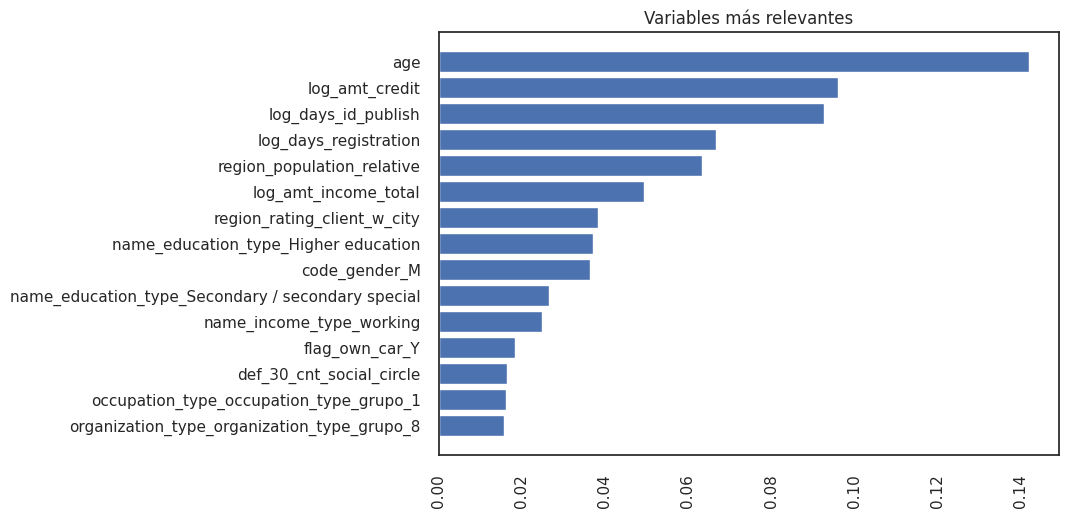

In [ ]:
df_importancias = feature_importance_rf(rf_best_model, df_clean_model_2.drop(['ext_source_2', 'ext_source_3'], axis=1))
df_importancias = df_importancias.reset_index()
df_importancias_15 = df_importancias.loc[:14,]
df_importancias_15 = df_importancias_15.sort_values(by='Importancia_abs')
plt.barh(df_importancias_15['Variable'],df_importancias_15['Importancia'])
plt.xticks(rotation = 90);
plt.title("Variables más relevantes");

De acuerdo a la gráfica anterior, identificamos que el atributo con mayor importancia para definir la morosidad de un cliente es la edad, con un 12% de importancia sobre los demas atributos. Además, la siguen en importancia los atributos: monto del crédito, cantidad de días previos a la postulacion, cantidad de días desde la última modificación de la información de un cliente, población donde vive el cliente, ingreso, entre otros.

# 8 Puntajes de corte

In [ ]:
# corremos el mejor modelo con los mejores hiperparametros
rf_model_final = RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=50, random_state=4392).fit(X_train_s, y_train_s)
# escalamos el dataset completo sin balancear
x_model_std = scaler.transform(df_clean_model)
# predecimos la probabilidad de que un cliente sea buen pagador
y_predict_proba=rf_model_final.predict_proba(x_model_std)[:,0] # prob de 0

## 8.1 Definición de puntajes de cortes


Según el monto solicitado para crédito se divide en deciles la cantidad de personas que lo solicitan y además la predicción de separa en percentiles (5%) para evaluar algún punto de corte, ya que la predicción indica que el 59,6% de los clientes son buenos pagadores (con un punto de corte del 50%)

In [ ]:
def dataset_primeros_percentiles(df,y_predict_proba):
  # creamos un dataset con las probabilidades obtenidas y el monto de crédito solicitado
  df_prob=pd.DataFrame({'monto_credito':list((10**df['log_amt_credit']).astype(int)),'prob': list(y_predict_proba)})
  # creamos una columna de percentiles para la cantidad de clientes con corte en el monto de crédito solicitado
  percentil_10=np.percentile(df_prob['monto_credito'], 10).astype(int)
  percentil_20=np.percentile(df_prob['monto_credito'], 20).astype(int)
  percentil_30=np.percentile(df_prob['monto_credito'], 30).astype(int)
  percentil_40=np.percentile(df_prob['monto_credito'], 40).astype(int)
  percentil_50=np.percentile(df_prob['monto_credito'], 50).astype(int)
  percentil_60=np.percentile(df_prob['monto_credito'], 60).astype(int)
  percentil_70=np.percentile(df_prob['monto_credito'], 70).astype(int)
  percentil_80=np.percentile(df_prob['monto_credito'], 80).astype(int)
  percentil_90=np.percentile(df_prob['monto_credito'], 90).astype(int)

  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_90,'[80-90]','[90-100]')
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_80,'[70-80]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_70,'[60-70]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_60,'[50-60]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_50,'[40-50]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_40,'[30-40]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_30,'[20-30]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_20,'[10-20]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_10,'[00-10]',df_prob['percentil_monto'])

  df_prob['monto_base']=np.where(df_prob['monto_credito']>=percentil_90,percentil_90,0)
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_90,percentil_80,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_80,percentil_70,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_70,percentil_60,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_60,percentil_50,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_50,percentil_40,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_40,percentil_30,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_30,percentil_20,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_20,percentil_10,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_10,0,df_prob['monto_base'])

  # creamos una columna con percentiles para la probabilidad ya predecida
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.95,'[90-95]','[95-100]')
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.90,'[85-90]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.85,'[80-85]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.80,'[75-80]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.75,'[70-75]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.70,'[65-70]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.65,'[60-65]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.60,'[55-60]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.55,'[50-55]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.50,'[45-50]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.45,'[40-45]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.40,'[35-40]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.35,'[30-35]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.30,'[25-30]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.25,'[20-25]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.20,'[15-20]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.15,'[10-15]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.10,'[05-10]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.05,'[00-05]',df_prob['percentil_proba'])

  # visualizamos la probabilidad de encontrar un buen pagador por percentiles según monto de crédito y probabilidad
  dinamica=pd.pivot_table(df_prob, values='monto_credito', index=['percentil_monto','monto_base'] , columns='percentil_proba',aggfunc='count',fill_value=0,margins=True)
  return dinamica

In [ ]:
dataset_primeros_percentiles(df_clean_model,y_predict_proba)

,percentil_proba,[15-20],[20-25],[25-30],[30-35],[35-40],[40-45],[45-50],[50-55],[55-60],[60-65],[65-70],[70-75],[75-80],[80-85],All
percentil_monto,monto_base,,,,,,,,,,,,,,,
[00-10],0,0,9,115,924,2761,3919,3738,3544,3606,3490,3433,1298,297,33,27167
[10-20],1677637439595,1,12,283,1606,3239,3522,3210,3361,3270,3479,3231,1422,446,115,27197
[20-30],3195281911577,2,47,453,2294,4099,4248,3921,4058,3669,3438,2288,486,52,2,29057
[30-40],5595196868887,2,44,550,2366,4277,4187,4056,4015,3394,3049,1359,173,13,0,27485
[40-50],10640283331748,2,32,330,1679,3328,3797,3938,4265,3857,3764,1864,274,28,1,27159
[50-60],15824296748903,1,23,415,1870,3789,4273,4362,4629,4023,3774,1458,170,13,0,28800
[60-70],25084418065035,0,6,81,631,1871,3476,4194,5058,5235,4743,2015,367,40,0,27717
[70-80],37111431994105,0,0,27,343,1393,3128,4611,5327,5527,4966,2204,409,43,2,27980
[80-90],56102997565255,0,3,17,138,797,2296,4042,5387,5703,5431,3020,751,85,4,27674


Dada la sensibilidad de los montos solicitados y la distribución del peso de clientes a través del cruce de percentiles, se propone al banco agrupar la predicción con 3 tipos de créditos y un puntaje para evaluación y otro para aprobación automática.

A todos los clientes con probabilidad de buen pagador bajo el 50% se les rechazará el crédito, el resto pasará a evaluación y de cumplir los siguientes requisitos se aprobará automáticamente:

1. Crédito S: Montos hasta 3.195.281.911.577 con una probabilidad de buen pagador superior al 60%

2. Crédito M: Montos entre 3.195.281.911.577 y 37.111.431.994.105 con una probabilidad de buen pagador superior al 65%

2. Crédito M: Montos superior a 37.111.431.994.105 con una probabilidad de buen pagador superior al 70%



In [ ]:
def tipos_creditos(df,y_predict_proba):
  # creamos un dataset con las probabilidades obtenidas y el monto de crédito solicitado
  df_prob=pd.DataFrame({'monto_credito':list((10**df['log_amt_credit']).astype(int)),'prob': list(y_predict_proba)})
  # creamos una columna de percentiles para la cantidad de clientes con corte en el monto de crédito solicitado
  percentil_10=np.percentile(df_prob['monto_credito'], 10).astype(int)
  percentil_20=np.percentile(df_prob['monto_credito'], 20).astype(int)
  percentil_30=np.percentile(df_prob['monto_credito'], 30).astype(int)
  percentil_40=np.percentile(df_prob['monto_credito'], 40).astype(int)
  percentil_50=np.percentile(df_prob['monto_credito'], 50).astype(int)
  percentil_60=np.percentile(df_prob['monto_credito'], 60).astype(int)
  percentil_70=np.percentile(df_prob['monto_credito'], 70).astype(int)
  percentil_80=np.percentile(df_prob['monto_credito'], 80).astype(int)
  percentil_90=np.percentile(df_prob['monto_credito'], 90).astype(int)

  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_90,'[80-90]','[90-100]')
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_80,'[70-80]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_70,'[60-70]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_60,'[50-60]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_50,'[40-50]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_40,'[30-40]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_30,'[20-30]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_20,'[10-20]',df_prob['percentil_monto'])
  df_prob['percentil_monto']=np.where(df_prob['monto_credito']<percentil_10,'[00-10]',df_prob['percentil_monto'])

  df_prob['monto_base']=np.where(df_prob['monto_credito']>=percentil_90,percentil_90,0)
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_90,percentil_80,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_80,percentil_70,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_70,percentil_60,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_60,percentil_50,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_50,percentil_40,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_40,percentil_30,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_30,percentil_20,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_20,percentil_10,df_prob['monto_base'])
  df_prob['monto_base']=np.where(df_prob['monto_credito']<percentil_10,0,df_prob['monto_base'])

  # creamos una columna con percentiles para la probabilidad ya predecida
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.95,'[90-95]','[95-100]')
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.90,'[85-90]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.85,'[80-85]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.80,'[75-80]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.75,'[70-75]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.70,'[65-70]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.65,'[60-65]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.60,'[55-60]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.55,'[50-55]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.50,'[45-50]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.45,'[40-45]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.40,'[35-40]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.35,'[30-35]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.30,'[25-30]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.25,'[20-25]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.20,'[15-20]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.15,'[10-15]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.10,'[05-10]',df_prob['percentil_proba'])
  df_prob['percentil_proba']=np.where(df_prob['prob']<0.05,'[00-05]',df_prob['percentil_proba'])

  # acotamos los créditos con 2 puntos de cortes
  df_prob['tipo_credito']=np.where(df_prob['monto_credito']<percentil_20,'A. Crédito S',0)
  df_prob['tipo_credito']=np.where(df_prob['monto_credito']>=percentil_20,'B. Crédito M',df_prob['tipo_credito'])
  df_prob['tipo_credito']=np.where(df_prob['monto_credito']>=percentil_70,'C. Crédito L',df_prob['tipo_credito'])

  df_prob['tramo_credito']=np.where(df_prob['monto_credito']<percentil_20,'$0 a $3.195.281.911.577',0)
  df_prob['tramo_credito']=np.where(df_prob['monto_credito']>=percentil_20,'$3.195.281.911.577 a $37.111.431.994.105',df_prob['tramo_credito'])
  df_prob['tramo_credito']=np.where(df_prob['monto_credito']>=percentil_70,'$37.111.431.994.105 o más',df_prob['tramo_credito'])

  # indicamos los criterios de aprobación
  df_prob['corte_aprueba']=np.where(df_prob['monto_credito']<percentil_20,'Superior a 60%',0)
  df_prob['corte_aprueba']=np.where(df_prob['monto_credito']>=percentil_20,'Superior a 65%',df_prob['corte_aprueba'])
  df_prob['corte_aprueba']=np.where(df_prob['monto_credito']>=percentil_70,'Superior a 70%',df_prob['corte_aprueba'])

  df_prob['criterio']='Rechazado'
  df_prob['criterio']=np.where(df_prob['prob']>=0.50,'Evaluación',df_prob['criterio'])
  df_prob['criterio']=np.where((df_prob['tipo_credito']=='C. Crédito L')&(df_prob['prob']>=0.70),'Aprobado',df_prob['criterio'])
  df_prob['criterio']=np.where((df_prob['tipo_credito']=='B. Crédito M')&(df_prob['prob']>=0.65),'Aprobado',df_prob['criterio'])
  df_prob['criterio']=np.where((df_prob['tipo_credito']=='A. Crédito S')&(df_prob['prob']>=0.60),'Aprobado',df_prob['criterio'])

  # indicamos los puntajes de corte para rechazo, evaluación y aprobación de un crédito
  dinamica1=pd.pivot_table(df_prob, values='monto_credito', index=['tipo_credito','tramo_credito','corte_aprueba'] , columns='criterio',aggfunc='count',fill_value=0,margins=True)
  return dinamica1

In [ ]:
tabla_y=tipos_creditos(df_clean_model,y_predict_proba)
tabla_y

,,criterio,Aprobado,Evaluación,Rechazado,All
tipo_credito,tramo_credito,corte_aprueba,,,,
A. Crédito S,$0 a $3.195.281.911.577,Superior a 60%,17244,13781,23339,54364
B. Crédito M,$3.195.281.911.577 a $37.111.431.994.105,Superior a 65%,10603,60971,68644,140218
C. Crédito L,$37.111.431.994.105 o más,Superior a 70%,3505,59828,20317,83650
All,,,31352,134580,112300,278232


In [ ]:
# se visualiza la cantidad de clientes porcentualmente
round(tabla_y.div(tabla_y.iloc[:,-1], axis=0),4)*100

,,criterio,Aprobado,Evaluación,Rechazado,All
tipo_credito,tramo_credito,corte_aprueba,,,,
A. Crédito S,$0 a $3.195.281.911.577,Superior a 60%,31.72,25.35,42.93,100.0
B. Crédito M,$3.195.281.911.577 a $37.111.431.994.105,Superior a 65%,7.56,43.48,48.96,100.0
C. Crédito L,$37.111.431.994.105 o más,Superior a 70%,4.19,71.52,24.29,100.0
All,,,11.27,48.37,40.36,100.0


## 8.2 Predicción de dataset de Validación

Se aplica la propuesta de negocio al dataset de validación.

In [ ]:
x_valid_std = scaler.transform(df_clean_valid)
y_predict_proba_valid=rf_model_final.predict_proba(x_valid_std)[:,0] # prob de 0

In [ ]:
def prediccion_corte(df_model,df_valid,y_predict_proba_v,y_predict_proba_m):
  df_prob=pd.DataFrame({'monto_credito':list((10**df_model['log_amt_credit']).astype(int)),'prob': list(y_predict_proba_m)})
  percentil_10=np.percentile(df_prob['monto_credito'], 10).astype(int)
  percentil_20=np.percentile(df_prob['monto_credito'], 20).astype(int)
  percentil_30=np.percentile(df_prob['monto_credito'], 30).astype(int)
  percentil_40=np.percentile(df_prob['monto_credito'], 40).astype(int)
  percentil_50=np.percentile(df_prob['monto_credito'], 50).astype(int)
  percentil_60=np.percentile(df_prob['monto_credito'], 60).astype(int)
  percentil_70=np.percentile(df_prob['monto_credito'], 70).astype(int)
  percentil_80=np.percentile(df_prob['monto_credito'], 80).astype(int)
  percentil_90=np.percentile(df_prob['monto_credito'], 90).astype(int)

  df_prob_valid=pd.DataFrame({'monto_credito':list((10**df_valid['log_amt_credit']).astype(int)),'prob': list(y_predict_proba_v)})
  df_prob_valid=df_prob_valid.sort_values(by='monto_credito', ascending=False).reset_index(drop=True)
  df_prob_valid.head()

  df_prob_valid['tipo_credito']=np.where(df_prob_valid['monto_credito']<percentil_20,'A. Crédito S',0)
  df_prob_valid['tipo_credito']=np.where(df_prob_valid['monto_credito']>=percentil_20,'B. Crédito M',df_prob_valid['tipo_credito'])
  df_prob_valid['tipo_credito']=np.where(df_prob_valid['monto_credito']>=percentil_70,'C. Crédito L',df_prob_valid['tipo_credito'])

  df_prob_valid['tramo_credito']=np.where(df_prob_valid['monto_credito']<percentil_20,'$0 a $3.195.281.911.577',0)
  df_prob_valid['tramo_credito']=np.where(df_prob_valid['monto_credito']>=percentil_20,'$3.195.281.911.577 a $37.111.431.994.105',df_prob_valid['tramo_credito'])
  df_prob_valid['tramo_credito']=np.where(df_prob_valid['monto_credito']>=percentil_70,'$37.111.431.994.105 o más',df_prob_valid['tramo_credito'])

  df_prob_valid['corte_aprueba']=np.where(df_prob_valid['monto_credito']<percentil_20,'Superior a 60%',0)
  df_prob_valid['corte_aprueba']=np.where(df_prob_valid['monto_credito']>=percentil_20,'Superior a 65%',df_prob_valid['corte_aprueba'])
  df_prob_valid['corte_aprueba']=np.where(df_prob_valid['monto_credito']>=percentil_70,'Superior a 70%',df_prob_valid['corte_aprueba'])

  df_prob_valid['criterio']='Rechazado'
  df_prob_valid['criterio']=np.where(df_prob_valid['prob']>=0.50,'Evaluación',df_prob_valid['criterio'])
  df_prob_valid['criterio']=np.where((df_prob_valid['tipo_credito']=='C. Crédito L')&(df_prob_valid['prob']>=0.70),'Aprobado',df_prob_valid['criterio'])
  df_prob_valid['criterio']=np.where((df_prob_valid['tipo_credito']=='B. Crédito M')&(df_prob_valid['prob']>=0.65),'Aprobado',df_prob_valid['criterio'])
  df_prob_valid['criterio']=np.where((df_prob_valid['tipo_credito']=='A. Crédito S')&(df_prob_valid['prob']>=0.60),'Aprobado',df_prob_valid['criterio'])

  dinamica3=pd.pivot_table(df_prob_valid, values='monto_credito', index=['tipo_credito','tramo_credito','corte_aprueba'] , columns='criterio',aggfunc='count',fill_value=0,margins=True)
  return dinamica3

In [ ]:
# se repite todo el ejercicio anterior pero con el dataset de validación
x_valid_std = scaler.transform(df_clean_valid)
y_predict_proba_valid=rf_model_final.predict_proba(x_valid_std)[:,0] # prob de 0

tabla_x=prediccion_corte(df_clean_model,df_clean_valid,y_predict_proba_valid,y_predict_proba)
tabla_x

,,criterio,Aprobado,Evaluación,Rechazado,All
tipo_credito,tramo_credito,corte_aprueba,,,,
A. Crédito S,$0 a $3.195.281.911.577,Superior a 60%,3772,3385,5469,12626
B. Crédito M,$3.195.281.911.577 a $37.111.431.994.105,Superior a 65%,2381,11883,12442,26706
C. Crédito L,$37.111.431.994.105 o más,Superior a 70%,555,6755,1663,8973
All,,,6708,22023,19574,48305


In [ ]:
round(tabla_x.div(tabla_x.iloc[:,-1], axis=0),4)*100

,,criterio,Aprobado,Evaluación,Rechazado,All
tipo_credito,tramo_credito,corte_aprueba,,,,
A. Crédito S,$0 a $3.195.281.911.577,Superior a 60%,29.87,26.81,43.32,100.0
B. Crédito M,$3.195.281.911.577 a $37.111.431.994.105,Superior a 65%,8.92,44.50,46.59,100.0
C. Crédito L,$37.111.431.994.105 o más,Superior a 70%,6.19,75.28,18.53,100.0
All,,,13.89,45.59,40.52,100.0


# 9 Comparación de predicción con puntajes externos

Se comparan los resultados del modelo predictivo con las fuentes externas donde en muy pocos percentiles la probabilidad de los puntajes externos coincide con el modelo realizado.

In [ ]:
def funcion_comparar(y_propio,y2,y3):
  df_modelo_vs=pd.DataFrame()
  df_modelo_vs['Probabilidad_modelo_propio']=y_propio
  df_modelo_vs['Probabilidad_modelo_externo_2']=y2
  df_modelo_vs['Probabilidad_modelo_externo_3']=y3

  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.90,'[80-90]','[90-100]')
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.80,'[70-80]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.70,'[60-70]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.60,'[50-60]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.50,'[40-50]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.40,'[30-40]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.30,'[20-30]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.20,'[10-20]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.10,'[00-10]',df_modelo_vs['percentil_proba_propio'])
  return round(df_modelo_vs.groupby(by=["percentil_proba_propio"]).mean(),2)

In [ ]:
# como dato adicional se compara la predicción del mejor modelo con los puntajes externos entregados en el dataset inicial
df_clean_model_2=df_clean_model_2.reset_index().drop(columns='index')
funcion_comparar(y_predict_proba,df_clean_model_2['ext_source_2'],df_clean_model_2['ext_source_3'])

,Probabilidad_modelo_propio,Probabilidad_modelo_externo_2,Probabilidad_modelo_externo_3
percentil_proba_propio,,,
[10-20],0.19,0.21,0.48
[20-30],0.28,0.36,0.45
[30-40],0.36,0.43,0.47
[40-50],0.45,0.49,0.50
[50-60],0.55,0.53,0.52
[60-70],0.64,0.56,0.54
[70-80],0.73,0.59,0.56
[80-90],0.82,0.60,0.57


Comparando los percentiles de las fuentes externas también se observa una muy baja coincidencia entre ambos modelos, por lo que faltan argumentos para indicar que algún modelo (incluido el propio) pueda ser mejor que el otro.
También considerando que la fuente externa 3 tenía datos nulos los cuales fueron reemplazos por su mediana para el análisis.

In [ ]:
def funcion_comparar_2(y_propio,y2,y3):
  df_modelo_vs=pd.DataFrame()
  df_modelo_vs['Probabilidad_modelo_propio']=y_propio
  df_modelo_vs['Probabilidad_modelo_externo_2']=y2
  df_modelo_vs['Probabilidad_modelo_externo_3']=y3

  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.90,'[80-90]','[90-100]')
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.80,'[70-80]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.70,'[60-70]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.60,'[50-60]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.50,'[40-50]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.40,'[30-40]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.30,'[20-30]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.20,'[10-20]',df_modelo_vs['percentil_proba_propio'])
  df_modelo_vs['percentil_proba_propio']=np.where(df_modelo_vs['Probabilidad_modelo_propio']<0.10,'[00-10]',df_modelo_vs['percentil_proba_propio'])

  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.90,'[80-90]','[90-100]')
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.80,'[70-80]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.70,'[60-70]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.60,'[50-60]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.50,'[40-50]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.40,'[30-40]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.30,'[20-30]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.20,'[10-20]',df_modelo_vs['percentil_proba_externo_2'])
  df_modelo_vs['percentil_proba_externo_2']=np.where(df_modelo_vs['Probabilidad_modelo_externo_2']<0.10,'[00-10]',df_modelo_vs['percentil_proba_externo_2'])

  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.90,'[80-90]','[90-100]')
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.80,'[70-80]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.70,'[60-70]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.60,'[50-60]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.50,'[40-50]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.40,'[30-40]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.30,'[20-30]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.20,'[10-20]',df_modelo_vs['percentil_proba_externo_3'])
  df_modelo_vs['percentil_proba_externo_3']=np.where(df_modelo_vs['Probabilidad_modelo_externo_3']<0.10,'[00-10]',df_modelo_vs['percentil_proba_externo_3'])
  dinamica5=pd.pivot_table(df_modelo_vs,values='Probabilidad_modelo_propio',index='percentil_proba_externo_2',columns='percentil_proba_externo_3',aggfunc='count',fill_value=0,margins=True)
  return round(dinamica5.div(len(df_modelo_vs), axis=0),4)*100

In [ ]:
# se visualiza la relación de grupos de percentiles con la cantidad de clientes según fuente de puntaje para aprobación
funcion_comparar_2(y_predict_proba,df_clean_model_2['ext_source_2'],df_clean_model_2['ext_source_3'])

percentil_proba_externo_3,[00-10],[10-20],[20-30],[30-40],[40-50],[50-60],[60-70],[70-80],[80-90],All
percentil_proba_externo_2,,,,,,,,,,
[00-10],0.14,0.29,0.37,0.43,0.44,1.35,0.40,0.29,0.07,3.77
[10-20],0.13,0.33,0.42,0.56,0.62,1.97,0.72,0.56,0.14,5.45
[20-30],0.17,0.39,0.58,0.78,0.92,2.79,1.11,0.82,0.21,7.77
[30-40],0.18,0.48,0.70,0.92,1.05,3.13,1.29,0.95,0.21,8.90
[40-50],0.24,0.64,0.94,1.27,1.48,4.24,1.82,1.34,0.30,12.26
[50-60],0.34,0.94,1.42,2.02,2.45,6.73,3.15,2.38,0.57,20.01
[60-70],0.38,1.09,1.74,2.57,3.22,8.75,4.46,3.64,0.91,26.76
[70-80],0.17,0.47,0.79,1.32,1.74,5.04,2.61,2.18,0.58,14.89
[80-90],0.00,0.01,0.01,0.01,0.02,0.07,0.04,0.02,0.01,0.19
